In [1]:
import os
import argparse
import pandas as pd
import numpy as np
import xgboost as xgb
from math import ceil
from math import sqrt
from math import acos
from operator import itemgetter
from itertools import product
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import gc
import seaborn as sns
from scipy import stats
from collections import defaultdict
from tqdm import tqdm
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import time

In [2]:
def load_data(vector_filename, ion_type):
    # Read file
    if vector_filename.split(".")[-1] == "pkl":
        vectors = pd.read_pickle(vector_filename)
    elif vector_filename.split(".")[-1] == "h5":
        # vectors = pd.read_hdf(vector_filename, key='table', stop=1000)
        vectors = pd.read_hdf(vector_filename, key="table")
    else:
        print("Unsuported feature vector format")
        exit(1)

    # Extract targets for given ion type
    target_names = list(vectors.columns[vectors.columns.str.contains("targets")])
    if not "targets_{}".format(ion_type) in target_names:
        print("Targets for {} could not be found in vector file.".format(ion_type))
        print("Vector file only contains these targets: {}".format(target_names))
        exit(1)

    targets = vectors.pop("targets_{}".format(ion_type))
    target_names.remove("targets_{}".format(ion_type))
    for n in target_names:
        vectors.pop(n)

    # Get psmids
    psmids = vectors.pop("psmid")

    return (vectors, targets, psmids)

In [3]:
def get_params_combinations(params):
    keys, values = zip(*params.items())
    combinations = [dict(zip(keys, v)) for v in product(*values)]
    return(combinations)

In [4]:
def get_best_params(df, params_grid):
    params = {}
    best = df[df['test-rmse-mean'] == df['test-rmse-mean'].min()]
    best_rmse = df['test-rmse-mean'].min()
    for p in params_grid.keys():
        params[p] = best[p].iloc[0]
    # num_boost_round = best['boosting-round'].iloc[0]
    return(params, best_rmse)

In [5]:
def gridsearch(xtrain, params, params_grid):
    cols = ['boosting-round', 'test-rmse-mean', 'test-rmse-std', 'train-rmse-mean', 'train-rmse-std']
    cols.extend(sorted(params_grid.keys()))
    result = pd.DataFrame(columns=cols)

    count = 1
    combinations = get_params_combinations(params_grid)

    for param_overrides in combinations:
        print("Working on combination {}/{}".format(count, len(combinations)))
        count += 1
        params.update(param_overrides)
        tmp = xgb.cv(params, xtrain, nfold=5, num_boost_round=200, early_stopping_rounds=10, verbose_eval=10)
        tmp['boosting-round'] = tmp.index
        for param in param_overrides.keys():
            tmp[param] = param_overrides[param]
        result = result.append(tmp)

    print("Grid search ready!\n")

    return(result)

In [6]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)

In [7]:
def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

# New scoring method

In [8]:
class Scorer:
    def __init__(self,psmids):
        self.psmids = psmids
        
    def psm_score(self,targets, predictions):
        tmp = pd.DataFrame(columns=["psmids", "targets", "predictions"])
        tmp["psmids"] = np.array(self.psmids)
        tmp["targets"] = np.array(targets)
        tmp["predictions"] = np.array(predictions)
        tmp2 = tmp.groupby("psmids").agg({'predictions': list, 'targets': list}).reset_index()
        spectral_corr = []
        pearson_corr = []
        for spectra in range(0, len(tmp2["psmids"])):
            spectral_corr.append(spectral_angle(np.array(tmp2.targets.loc[spectra]), np.array(tmp2.predictions.loc[spectra])))
            pearson_corr.append(ms2pip_pearson(np.array(tmp2.targets.loc[spectra]), np.array(tmp2.predictions.loc[spectra])))
        return (pearson_corr, spectral_corr) 

# Non tryptic Y_model

In [9]:
vectors, targets, psmids = load_data("data/non_tryptic_train.pkl", "Y")

In [10]:
upeps = psmids.unique()
np.random.shuffle(upeps)
test_psms = upeps[:int(len(upeps) * 0.1)]

train_vectors = vectors[~psmids.isin(test_psms)]
train_targets = targets[~psmids.isin(test_psms)]
train_psmids = psmids[~psmids.isin(test_psms)]

test_vectors = vectors[psmids.isin(test_psms)]
test_targets = targets[psmids.isin(test_psms)]
test_psmids = psmids[psmids.isin(test_psms)]

In [11]:
xtrain = xgb.DMatrix(train_vectors, label=train_targets)
xtest = xgb.DMatrix(test_vectors, label=test_targets)
evallist = [(xtrain, 'train'),(xtest, 'test')]

In [12]:
space= {
    'eta': hp.loguniform('eta', np.log(0.01), np.log(1)),
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'max_leaves': hp.quniform('max_leaves', 5, 500, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'gamma' : hp.uniform ('gamma', 0.0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 500, 1),
    'subsample': hp.quniform('subsample', 0.5, 1 ,0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 5 ,0.1)
}

In [13]:
def objective(space):
    params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    "eval_metric": 'rmse',
    "eta": space["eta"],
    "max_depth": int(space['max_depth']),
    "grow_policy":"lossguide",
    "max_leaves":int(space["max_leaves"]),
    "min_child_weight": int(space["min_child_weight"]),
    "gamma": space['gamma'],
    "reg_lambda" : space['reg_lambda'],
    "colsample_bytree": space['colsample_bytree'],
    "subsample" : space["subsample"],
    "reg_alpha" : space["reg_alpha"]
    }
    print(params)
    tmp = xgb.cv(params, xtrain, nfold=4, num_boost_round=400, early_stopping_rounds=10, verbose_eval=True)
    rmse = tmp['test-rmse-mean'].min()

    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK, "params": params}

In [14]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)


best_hyperparams

{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.5310210907954473, 'max_depth': 11, 'grow_policy': 'lossguide', 'max_leaves': 470, 'min_child_weight': 417, 'gamma': 0.27694112818400085, 'reg_lambda': 0.84211650905364, 'colsample_bytree': 0.6741898345035984, 'subsample': 0.7000000000000001, 'reg_alpha': 0.30000000000000004}
[0]	train-rmse:4.38248+0.00105	test-rmse:4.38312+0.00121

[1]	train-rmse:2.28205+0.00183	test-rmse:2.28382+0.00172

[2]	train-rmse:1.43011+0.00826	test-rmse:1.43371+0.00845

[3]	train-rmse:1.13867+0.00479	test-rmse:1.14408+0.00556

[4]	train-rmse:1.05078+0.00473	test-rmse:1.05765+0.00573

[5]	train-rmse:1.01632+0.00575	test-rmse:1.02432+0.00555

[6]	train-rmse:1.00017+0.00345	test-rmse:1.00931+0.00384

[7]	train-rmse:0.98888+0.00374	test-rmse:0.99906+0.00327

[8]	train-rmse:0.97984+0.00216	test-rmse:0.99112+0.00238

[9]	train-rmse:0.97260+0.00223	test-rmse:0.98469+0.00277

[10]	train-rmse:0.96537+0.00177	test-rmse:0.97852+0.00265

[11]

[268]	train-rmse:0.77732+0.00216	test-rmse:0.89173+0.00226

[269]	train-rmse:0.77703+0.00218	test-rmse:0.89172+0.00225

[270]	train-rmse:0.77665+0.00205	test-rmse:0.89165+0.00219

[271]	train-rmse:0.77640+0.00212	test-rmse:0.89164+0.00218

[272]	train-rmse:0.77607+0.00205	test-rmse:0.89160+0.00220

[273]	train-rmse:0.77577+0.00194	test-rmse:0.89155+0.00219

[274]	train-rmse:0.77541+0.00178	test-rmse:0.89153+0.00214

[275]	train-rmse:0.77511+0.00175	test-rmse:0.89154+0.00216

[276]	train-rmse:0.77471+0.00184	test-rmse:0.89148+0.00215

[277]	train-rmse:0.77439+0.00170	test-rmse:0.89148+0.00216

[278]	train-rmse:0.77401+0.00179	test-rmse:0.89142+0.00216

[279]	train-rmse:0.77371+0.00182	test-rmse:0.89138+0.00216

[280]	train-rmse:0.77344+0.00189	test-rmse:0.89139+0.00214

[281]	train-rmse:0.77310+0.00194	test-rmse:0.89136+0.00216

[282]	train-rmse:0.77287+0.00194	test-rmse:0.89136+0.00215

[283]	train-rmse:0.77255+0.00200	test-rmse:0.89135+0.00214

[284]	train-rmse:0.77227+0.00199	test-rm

[0]	train-rmse:8.96400+0.00087	test-rmse:8.96385+0.00259                             

[1]	train-rmse:8.86503+0.00074	test-rmse:8.86503+0.00257                             

[2]	train-rmse:8.76737+0.00086	test-rmse:8.76734+0.00258                             

[3]	train-rmse:8.67069+0.00082	test-rmse:8.67080+0.00256                             

[4]	train-rmse:8.57557+0.00098	test-rmse:8.57543+0.00240                             

[5]	train-rmse:8.48094+0.00102	test-rmse:8.48099+0.00233                             

[6]	train-rmse:8.38785+0.00108	test-rmse:8.38789+0.00225                             

[7]	train-rmse:8.29568+0.00114	test-rmse:8.29576+0.00216                             

[8]	train-rmse:8.20472+0.00097	test-rmse:8.20473+0.00231                             

[9]	train-rmse:8.11459+0.00100	test-rmse:8.11460+0.00225                             

[10]	train-rmse:8.02549+0.00085	test-rmse:8.02558+0.00240                            

[11]	train-rmse:7.93739+0.00085	test-rmse:7

[188]	train-rmse:1.51152+0.00055	test-rmse:1.51431+0.00110                           

[189]	train-rmse:1.50267+0.00053	test-rmse:1.50548+0.00124                           

[190]	train-rmse:1.49389+0.00046	test-rmse:1.49673+0.00124                           

[191]	train-rmse:1.48528+0.00040	test-rmse:1.48815+0.00128                           

[192]	train-rmse:1.47689+0.00041	test-rmse:1.47979+0.00129                           

[193]	train-rmse:1.46856+0.00040	test-rmse:1.47149+0.00137                           

[194]	train-rmse:1.46035+0.00043	test-rmse:1.46330+0.00137                           

[195]	train-rmse:1.45225+0.00051	test-rmse:1.45523+0.00146                           

[196]	train-rmse:1.44431+0.00051	test-rmse:1.44732+0.00140                           

[197]	train-rmse:1.43640+0.00053	test-rmse:1.43944+0.00142                           

[198]	train-rmse:1.42869+0.00054	test-rmse:1.43176+0.00142                           

[199]	train-rmse:1.42112+0.00049	test-rmse:

[376]	train-rmse:0.99416+0.00089	test-rmse:1.00124+0.00183                           

[377]	train-rmse:0.99369+0.00086	test-rmse:1.00079+0.00179                           

[378]	train-rmse:0.99321+0.00090	test-rmse:1.00033+0.00175                           

[379]	train-rmse:0.99271+0.00086	test-rmse:0.99984+0.00172                           

[380]	train-rmse:0.99224+0.00079	test-rmse:0.99939+0.00174                           

[381]	train-rmse:0.99178+0.00079	test-rmse:0.99894+0.00172                           

[382]	train-rmse:0.99138+0.00077	test-rmse:0.99856+0.00166                           

[383]	train-rmse:0.99095+0.00078	test-rmse:0.99814+0.00168                           

[384]	train-rmse:0.99048+0.00077	test-rmse:0.99769+0.00168                           

[385]	train-rmse:0.99005+0.00086	test-rmse:0.99728+0.00165                           

[386]	train-rmse:0.98963+0.00088	test-rmse:0.99688+0.00169                           

[387]	train-rmse:0.98926+0.00089	test-rmse:

[159]	train-rmse:0.71242+0.00066	test-rmse:0.83364+0.00195                            

[160]	train-rmse:0.71179+0.00050	test-rmse:0.83355+0.00190                            

[161]	train-rmse:0.71126+0.00044	test-rmse:0.83341+0.00183                            

[162]	train-rmse:0.71084+0.00045	test-rmse:0.83333+0.00182                            

[163]	train-rmse:0.71030+0.00039	test-rmse:0.83324+0.00183                            

[164]	train-rmse:0.70984+0.00035	test-rmse:0.83314+0.00184                            

[165]	train-rmse:0.70941+0.00039	test-rmse:0.83306+0.00184                            

[166]	train-rmse:0.70881+0.00048	test-rmse:0.83297+0.00183                            

[167]	train-rmse:0.70830+0.00063	test-rmse:0.83289+0.00186                            

[168]	train-rmse:0.70769+0.00072	test-rmse:0.83278+0.00187                            

[169]	train-rmse:0.70705+0.00075	test-rmse:0.83264+0.00186                            

[170]	train-rmse:0.70654+0.00091

[345]	train-rmse:0.62924+0.00129	test-rmse:0.82426+0.00128                            

[346]	train-rmse:0.62879+0.00137	test-rmse:0.82422+0.00127                            

[347]	train-rmse:0.62850+0.00132	test-rmse:0.82420+0.00129                            

[348]	train-rmse:0.62810+0.00121	test-rmse:0.82419+0.00130                            

[349]	train-rmse:0.62775+0.00123	test-rmse:0.82416+0.00132                            

[350]	train-rmse:0.62735+0.00131	test-rmse:0.82414+0.00133                            

[351]	train-rmse:0.62698+0.00140	test-rmse:0.82412+0.00132                            

[352]	train-rmse:0.62654+0.00149	test-rmse:0.82409+0.00132                            

[353]	train-rmse:0.62608+0.00154	test-rmse:0.82406+0.00131                            

[354]	train-rmse:0.62574+0.00163	test-rmse:0.82403+0.00131                            

[355]	train-rmse:0.62532+0.00162	test-rmse:0.82402+0.00131                            

[356]	train-rmse:0.62501+0.00165

[135]	train-rmse:1.02541+0.00044	test-rmse:1.02922+0.00205                     

[136]	train-rmse:1.02436+0.00059	test-rmse:1.02819+0.00175                     

[137]	train-rmse:1.02345+0.00076	test-rmse:1.02731+0.00168                     

[138]	train-rmse:1.02258+0.00073	test-rmse:1.02645+0.00161                     

[139]	train-rmse:1.02161+0.00058	test-rmse:1.02549+0.00157                     

[140]	train-rmse:1.02088+0.00053	test-rmse:1.02478+0.00166                     

[141]	train-rmse:1.02012+0.00054	test-rmse:1.02405+0.00165                     

[142]	train-rmse:1.01912+0.00060	test-rmse:1.02308+0.00171                     

[143]	train-rmse:1.01829+0.00061	test-rmse:1.02227+0.00153                     

[144]	train-rmse:1.01742+0.00063	test-rmse:1.02142+0.00165                     

[145]	train-rmse:1.01666+0.00068	test-rmse:1.02067+0.00180                     

[146]	train-rmse:1.01593+0.00071	test-rmse:1.01997+0.00179                     

[147]	train-rmse:1.01533+0.0

[337]	train-rmse:0.94705+0.00036	test-rmse:0.95467+0.00191                     

[338]	train-rmse:0.94688+0.00030	test-rmse:0.95451+0.00192                     

[339]	train-rmse:0.94668+0.00027	test-rmse:0.95433+0.00191                     

[340]	train-rmse:0.94645+0.00022	test-rmse:0.95413+0.00194                     

[341]	train-rmse:0.94625+0.00015	test-rmse:0.95394+0.00198                     

[342]	train-rmse:0.94598+0.00013	test-rmse:0.95369+0.00202                     

[343]	train-rmse:0.94578+0.00017	test-rmse:0.95351+0.00204                     

[344]	train-rmse:0.94559+0.00019	test-rmse:0.95334+0.00201                     

[345]	train-rmse:0.94540+0.00022	test-rmse:0.95317+0.00202                     

[346]	train-rmse:0.94522+0.00024	test-rmse:0.95301+0.00197                     

[347]	train-rmse:0.94499+0.00025	test-rmse:0.95279+0.00202                     

[348]	train-rmse:0.94474+0.00026	test-rmse:0.95256+0.00195                     

[349]	train-rmse:0.94454+0.0

[134]	train-rmse:1.02222+0.00230	test-rmse:1.02583+0.00229                    

[135]	train-rmse:1.02145+0.00232	test-rmse:1.02506+0.00226                    

[136]	train-rmse:1.02079+0.00219	test-rmse:1.02444+0.00213                    

[137]	train-rmse:1.02022+0.00221	test-rmse:1.02388+0.00207                    

[138]	train-rmse:1.01963+0.00203	test-rmse:1.02333+0.00193                    

[139]	train-rmse:1.01900+0.00226	test-rmse:1.02271+0.00191                    

[140]	train-rmse:1.01826+0.00204	test-rmse:1.02198+0.00173                    

[141]	train-rmse:1.01755+0.00209	test-rmse:1.02130+0.00196                    

[142]	train-rmse:1.01696+0.00220	test-rmse:1.02072+0.00189                    

[143]	train-rmse:1.01643+0.00201	test-rmse:1.02020+0.00182                    

[144]	train-rmse:1.01582+0.00191	test-rmse:1.01961+0.00178                    

[145]	train-rmse:1.01513+0.00180	test-rmse:1.01894+0.00171                    

[146]	train-rmse:1.01467+0.00182	test-rm

[338]	train-rmse:0.95113+0.00149	test-rmse:0.95871+0.00315                    

[339]	train-rmse:0.95087+0.00150	test-rmse:0.95848+0.00319                    

[340]	train-rmse:0.95056+0.00149	test-rmse:0.95818+0.00313                    

[341]	train-rmse:0.95032+0.00157	test-rmse:0.95796+0.00323                    

[342]	train-rmse:0.95009+0.00150	test-rmse:0.95776+0.00320                    

[343]	train-rmse:0.94993+0.00149	test-rmse:0.95762+0.00317                    

[344]	train-rmse:0.94973+0.00155	test-rmse:0.95743+0.00320                    

[345]	train-rmse:0.94940+0.00153	test-rmse:0.95712+0.00314                    

[346]	train-rmse:0.94921+0.00157	test-rmse:0.95694+0.00319                    

[347]	train-rmse:0.94903+0.00155	test-rmse:0.95678+0.00314                    

[348]	train-rmse:0.94889+0.00154	test-rmse:0.95665+0.00316                    

[349]	train-rmse:0.94869+0.00163	test-rmse:0.95646+0.00327                    

[350]	train-rmse:0.94848+0.00158	test-rm

[136]	train-rmse:0.81430+0.00078	test-rmse:0.86623+0.00208                    

[137]	train-rmse:0.81359+0.00062	test-rmse:0.86580+0.00204                    

[138]	train-rmse:0.81296+0.00069	test-rmse:0.86543+0.00202                    

[139]	train-rmse:0.81208+0.00084	test-rmse:0.86490+0.00189                    

[140]	train-rmse:0.81127+0.00089	test-rmse:0.86441+0.00191                    

[141]	train-rmse:0.81062+0.00083	test-rmse:0.86401+0.00195                    

[142]	train-rmse:0.80997+0.00085	test-rmse:0.86361+0.00196                    

[143]	train-rmse:0.80927+0.00074	test-rmse:0.86320+0.00199                    

[144]	train-rmse:0.80851+0.00062	test-rmse:0.86276+0.00199                    

[145]	train-rmse:0.80786+0.00080	test-rmse:0.86235+0.00193                    

[146]	train-rmse:0.80719+0.00085	test-rmse:0.86197+0.00189                    

[147]	train-rmse:0.80657+0.00079	test-rmse:0.86159+0.00185                    

[148]	train-rmse:0.80584+0.00054	test-rm

[340]	train-rmse:0.71634+0.00153	test-rmse:0.81923+0.00177                    

[341]	train-rmse:0.71602+0.00144	test-rmse:0.81911+0.00177                    

[342]	train-rmse:0.71565+0.00137	test-rmse:0.81895+0.00174                    

[343]	train-rmse:0.71532+0.00142	test-rmse:0.81882+0.00171                    

[344]	train-rmse:0.71496+0.00138	test-rmse:0.81871+0.00171                    

[345]	train-rmse:0.71457+0.00134	test-rmse:0.81857+0.00168                    

[346]	train-rmse:0.71426+0.00119	test-rmse:0.81844+0.00169                    

[347]	train-rmse:0.71400+0.00125	test-rmse:0.81835+0.00170                    

[348]	train-rmse:0.71367+0.00126	test-rmse:0.81824+0.00169                    

[349]	train-rmse:0.71341+0.00125	test-rmse:0.81815+0.00170                    

[350]	train-rmse:0.71317+0.00122	test-rmse:0.81806+0.00166                    

[351]	train-rmse:0.71284+0.00122	test-rmse:0.81794+0.00169                    

[352]	train-rmse:0.71249+0.00138	test-rm

[139]	train-rmse:0.78685+0.00084	test-rmse:0.84453+0.00191                   

[140]	train-rmse:0.78626+0.00081	test-rmse:0.84424+0.00192                   

[141]	train-rmse:0.78570+0.00082	test-rmse:0.84397+0.00187                   

[142]	train-rmse:0.78540+0.00076	test-rmse:0.84384+0.00186                   

[143]	train-rmse:0.78509+0.00083	test-rmse:0.84371+0.00185                   

[144]	train-rmse:0.78457+0.00062	test-rmse:0.84346+0.00190                   

[145]	train-rmse:0.78417+0.00044	test-rmse:0.84326+0.00192                   

[146]	train-rmse:0.78357+0.00042	test-rmse:0.84300+0.00190                   

[147]	train-rmse:0.78317+0.00030	test-rmse:0.84284+0.00190                   

[148]	train-rmse:0.78270+0.00035	test-rmse:0.84259+0.00188                   

[149]	train-rmse:0.78239+0.00031	test-rmse:0.84245+0.00194                   

[150]	train-rmse:0.78202+0.00057	test-rmse:0.84230+0.00198                   

[151]	train-rmse:0.78156+0.00048	test-rmse:0.84208+0

[345]	train-rmse:0.72715+0.00134	test-rmse:0.82114+0.00147                   

[346]	train-rmse:0.72691+0.00137	test-rmse:0.82105+0.00143                   

[347]	train-rmse:0.72674+0.00123	test-rmse:0.82100+0.00144                   

[348]	train-rmse:0.72654+0.00114	test-rmse:0.82094+0.00144                   

[349]	train-rmse:0.72641+0.00116	test-rmse:0.82091+0.00143                   

[350]	train-rmse:0.72616+0.00112	test-rmse:0.82085+0.00143                   

[351]	train-rmse:0.72596+0.00097	test-rmse:0.82079+0.00146                   

[352]	train-rmse:0.72566+0.00102	test-rmse:0.82070+0.00145                   

[353]	train-rmse:0.72550+0.00103	test-rmse:0.82065+0.00144                   

[354]	train-rmse:0.72521+0.00108	test-rmse:0.82056+0.00143                   

[355]	train-rmse:0.72502+0.00102	test-rmse:0.82051+0.00141                   

[356]	train-rmse:0.72482+0.00108	test-rmse:0.82045+0.00142                   

[357]	train-rmse:0.72468+0.00110	test-rmse:0.82040+0

[145]	train-rmse:1.36659+0.00069	test-rmse:1.36683+0.00186                   

[146]	train-rmse:1.36537+0.00067	test-rmse:1.36561+0.00172                   

[147]	train-rmse:1.36426+0.00088	test-rmse:1.36450+0.00198                   

[148]	train-rmse:1.36318+0.00082	test-rmse:1.36341+0.00204                   

[149]	train-rmse:1.36229+0.00084	test-rmse:1.36252+0.00205                   

[150]	train-rmse:1.36108+0.00099	test-rmse:1.36131+0.00196                   

[151]	train-rmse:1.35995+0.00101	test-rmse:1.36017+0.00190                   

[152]	train-rmse:1.35891+0.00077	test-rmse:1.35913+0.00169                   

[153]	train-rmse:1.35787+0.00085	test-rmse:1.35810+0.00196                   

[154]	train-rmse:1.35689+0.00085	test-rmse:1.35712+0.00198                   

[155]	train-rmse:1.35564+0.00115	test-rmse:1.35587+0.00201                   

[156]	train-rmse:1.35459+0.00103	test-rmse:1.35483+0.00181                   

[157]	train-rmse:1.35356+0.00065	test-rmse:1.35380+0

[351]	train-rmse:1.24249+0.00051	test-rmse:1.24291+0.00209                   

[352]	train-rmse:1.24214+0.00055	test-rmse:1.24256+0.00214                   

[353]	train-rmse:1.24181+0.00048	test-rmse:1.24223+0.00210                   

[354]	train-rmse:1.24138+0.00033	test-rmse:1.24181+0.00197                   

[355]	train-rmse:1.24112+0.00036	test-rmse:1.24154+0.00198                   

[356]	train-rmse:1.24068+0.00041	test-rmse:1.24110+0.00196                   

[357]	train-rmse:1.24040+0.00042	test-rmse:1.24083+0.00195                   

[358]	train-rmse:1.24015+0.00043	test-rmse:1.24058+0.00196                   

[359]	train-rmse:1.23980+0.00031	test-rmse:1.24022+0.00185                   

[360]	train-rmse:1.23949+0.00043	test-rmse:1.23991+0.00179                   

[361]	train-rmse:1.23919+0.00043	test-rmse:1.23962+0.00182                   

[362]	train-rmse:1.23894+0.00039	test-rmse:1.23937+0.00181                   

[363]	train-rmse:1.23864+0.00038	test-rmse:1.23907+0

[151]	train-rmse:0.84013+0.00255	test-rmse:0.93662+0.00226                   

[152]	train-rmse:0.83965+0.00255	test-rmse:0.93663+0.00227                   

[153]	train-rmse:0.83920+0.00260	test-rmse:0.93661+0.00224                   

[154]	train-rmse:0.83855+0.00254	test-rmse:0.93660+0.00223                   

[155]	train-rmse:0.83808+0.00261	test-rmse:0.93652+0.00226                   

[156]	train-rmse:0.83755+0.00250	test-rmse:0.93652+0.00225                   

[157]	train-rmse:0.83707+0.00246	test-rmse:0.93647+0.00232                   

[158]	train-rmse:0.83666+0.00245	test-rmse:0.93648+0.00232                   

[159]	train-rmse:0.83635+0.00241	test-rmse:0.93647+0.00235                   

[160]	train-rmse:0.83598+0.00242	test-rmse:0.93644+0.00238                   

[161]	train-rmse:0.83540+0.00234	test-rmse:0.93641+0.00234                   

[162]	train-rmse:0.83486+0.00238	test-rmse:0.93637+0.00241                   

[163]	train-rmse:0.83438+0.00231	test-rmse:0.93637+0

[32]	train-rmse:0.91179+0.00123	test-rmse:0.93062+0.00233                    

[33]	train-rmse:0.90947+0.00118	test-rmse:0.92873+0.00250                    

[34]	train-rmse:0.90733+0.00093	test-rmse:0.92702+0.00261                    

[35]	train-rmse:0.90534+0.00108	test-rmse:0.92548+0.00238                    

[36]	train-rmse:0.90294+0.00088	test-rmse:0.92354+0.00198                    

[37]	train-rmse:0.90028+0.00043	test-rmse:0.92139+0.00240                    

[38]	train-rmse:0.89829+0.00041	test-rmse:0.91985+0.00214                    

[39]	train-rmse:0.89666+0.00065	test-rmse:0.91860+0.00250                    

[40]	train-rmse:0.89492+0.00043	test-rmse:0.91722+0.00235                    

[41]	train-rmse:0.89328+0.00060	test-rmse:0.91591+0.00165                    

[42]	train-rmse:0.89138+0.00052	test-rmse:0.91447+0.00183                    

[43]	train-rmse:0.88964+0.00045	test-rmse:0.91316+0.00197                    

[44]	train-rmse:0.88836+0.00054	test-rmse:0.91226+0.

[238]	train-rmse:0.76278+0.00155	test-rmse:0.84187+0.00204                   

[239]	train-rmse:0.76232+0.00176	test-rmse:0.84165+0.00208                   

[240]	train-rmse:0.76192+0.00169	test-rmse:0.84147+0.00216                   

[241]	train-rmse:0.76164+0.00161	test-rmse:0.84138+0.00216                   

[242]	train-rmse:0.76134+0.00157	test-rmse:0.84127+0.00221                   

[243]	train-rmse:0.76104+0.00152	test-rmse:0.84116+0.00221                   

[244]	train-rmse:0.76071+0.00153	test-rmse:0.84103+0.00219                   

[245]	train-rmse:0.76037+0.00169	test-rmse:0.84089+0.00226                   

[246]	train-rmse:0.76005+0.00179	test-rmse:0.84077+0.00223                   

[247]	train-rmse:0.75973+0.00181	test-rmse:0.84063+0.00231                   

[248]	train-rmse:0.75931+0.00174	test-rmse:0.84047+0.00238                   

[249]	train-rmse:0.75890+0.00179	test-rmse:0.84031+0.00236                   

[250]	train-rmse:0.75863+0.00173	test-rmse:0.84021+0

[38]	train-rmse:6.05128+0.00055	test-rmse:6.05131+0.00214                    

[39]	train-rmse:5.98980+0.00051	test-rmse:5.98982+0.00216                    

[40]	train-rmse:5.92892+0.00047	test-rmse:5.92897+0.00219                    

[41]	train-rmse:5.86875+0.00051	test-rmse:5.86886+0.00216                    

[42]	train-rmse:5.80920+0.00050	test-rmse:5.80931+0.00216                    

[43]	train-rmse:5.75044+0.00048	test-rmse:5.75050+0.00212                    

[44]	train-rmse:5.69218+0.00049	test-rmse:5.69227+0.00214                    

[45]	train-rmse:5.63461+0.00050	test-rmse:5.63466+0.00211                    

[46]	train-rmse:5.57765+0.00048	test-rmse:5.57773+0.00210                    

[47]	train-rmse:5.52138+0.00037	test-rmse:5.52149+0.00221                    

[48]	train-rmse:5.46571+0.00032	test-rmse:5.46582+0.00224                    

[49]	train-rmse:5.41069+0.00033	test-rmse:5.41080+0.00222                    

[50]	train-rmse:5.35627+0.00037	test-rmse:5.35638+0.

[244]	train-rmse:1.31619+0.00042	test-rmse:1.31756+0.00104                   

[245]	train-rmse:1.31224+0.00034	test-rmse:1.31362+0.00114                   

[246]	train-rmse:1.30838+0.00032	test-rmse:1.30976+0.00113                   

[247]	train-rmse:1.30457+0.00030	test-rmse:1.30597+0.00116                   

[248]	train-rmse:1.30090+0.00024	test-rmse:1.30230+0.00124                   

[249]	train-rmse:1.29724+0.00026	test-rmse:1.29865+0.00121                   

[250]	train-rmse:1.29372+0.00026	test-rmse:1.29513+0.00123                   

[251]	train-rmse:1.29007+0.00038	test-rmse:1.29149+0.00110                   

[252]	train-rmse:1.28653+0.00031	test-rmse:1.28796+0.00114                   

[253]	train-rmse:1.28307+0.00035	test-rmse:1.28451+0.00111                   

[254]	train-rmse:1.27948+0.00025	test-rmse:1.28093+0.00120                   

[255]	train-rmse:1.27611+0.00040	test-rmse:1.27757+0.00107                   

[256]	train-rmse:1.27286+0.00038	test-rmse:1.27432+0

[44]	train-rmse:1.33968+0.00368	test-rmse:1.34023+0.00401                    

[45]	train-rmse:1.32702+0.00380	test-rmse:1.32757+0.00423                    

[46]	train-rmse:1.31571+0.00418	test-rmse:1.31626+0.00462                    

[47]	train-rmse:1.30562+0.00378	test-rmse:1.30620+0.00429                    

[48]	train-rmse:1.29628+0.00350	test-rmse:1.29689+0.00410                    

[49]	train-rmse:1.28799+0.00346	test-rmse:1.28862+0.00406                    

[50]	train-rmse:1.27928+0.00433	test-rmse:1.27990+0.00516                    

[51]	train-rmse:1.27167+0.00457	test-rmse:1.27229+0.00548                    

[52]	train-rmse:1.26508+0.00452	test-rmse:1.26571+0.00545                    

[53]	train-rmse:1.25927+0.00427	test-rmse:1.25991+0.00529                    

[54]	train-rmse:1.25330+0.00401	test-rmse:1.25396+0.00491                    

[55]	train-rmse:1.24805+0.00375	test-rmse:1.24871+0.00444                    

[56]	train-rmse:1.24321+0.00392	test-rmse:1.24389+0.

[250]	train-rmse:1.05976+0.00200	test-rmse:1.06176+0.00389                   

[251]	train-rmse:1.05937+0.00196	test-rmse:1.06139+0.00373                   

[252]	train-rmse:1.05916+0.00187	test-rmse:1.06118+0.00363                   

[253]	train-rmse:1.05867+0.00194	test-rmse:1.06069+0.00380                   

[254]	train-rmse:1.05846+0.00194	test-rmse:1.06050+0.00378                   

[255]	train-rmse:1.05828+0.00188	test-rmse:1.06032+0.00371                   

[256]	train-rmse:1.05796+0.00196	test-rmse:1.06002+0.00377                   

[257]	train-rmse:1.05755+0.00193	test-rmse:1.05962+0.00363                   

[258]	train-rmse:1.05712+0.00209	test-rmse:1.05918+0.00385                   

[259]	train-rmse:1.05679+0.00204	test-rmse:1.05886+0.00378                   

[260]	train-rmse:1.05651+0.00216	test-rmse:1.05859+0.00388                   

[261]	train-rmse:1.05618+0.00211	test-rmse:1.05826+0.00384                   

[262]	train-rmse:1.05566+0.00217	test-rmse:1.05775+0

[50]	train-rmse:1.89665+0.00046	test-rmse:1.89973+0.00153                    

[51]	train-rmse:1.85130+0.00040	test-rmse:1.85450+0.00152                    

[52]	train-rmse:1.80779+0.00038	test-rmse:1.81110+0.00141                    

[53]	train-rmse:1.76600+0.00044	test-rmse:1.76943+0.00150                    

[54]	train-rmse:1.72590+0.00038	test-rmse:1.72947+0.00159                    

[55]	train-rmse:1.68758+0.00035	test-rmse:1.69128+0.00160                    

[56]	train-rmse:1.65097+0.00040	test-rmse:1.65481+0.00168                    

[57]	train-rmse:1.61599+0.00035	test-rmse:1.61996+0.00174                    

[58]	train-rmse:1.58263+0.00036	test-rmse:1.58673+0.00163                    

[59]	train-rmse:1.55056+0.00039	test-rmse:1.55479+0.00174                    

[60]	train-rmse:1.51990+0.00042	test-rmse:1.52428+0.00166                    

[61]	train-rmse:1.49066+0.00045	test-rmse:1.49518+0.00180                    

[62]	train-rmse:1.46284+0.00041	test-rmse:1.46751+0.

[256]	train-rmse:0.88161+0.00041	test-rmse:0.90091+0.00231                   

[257]	train-rmse:0.88135+0.00048	test-rmse:0.90070+0.00233                   

[258]	train-rmse:0.88111+0.00047	test-rmse:0.90051+0.00234                   

[259]	train-rmse:0.88085+0.00044	test-rmse:0.90030+0.00233                   

[260]	train-rmse:0.88061+0.00038	test-rmse:0.90011+0.00234                   

[261]	train-rmse:0.88032+0.00029	test-rmse:0.89988+0.00232                   

[262]	train-rmse:0.88007+0.00030	test-rmse:0.89968+0.00232                   

[263]	train-rmse:0.87974+0.00040	test-rmse:0.89941+0.00238                   

[264]	train-rmse:0.87950+0.00048	test-rmse:0.89922+0.00243                   

[265]	train-rmse:0.87931+0.00042	test-rmse:0.89907+0.00240                   

[266]	train-rmse:0.87905+0.00037	test-rmse:0.89886+0.00239                   

[267]	train-rmse:0.87880+0.00040	test-rmse:0.89867+0.00240                   

[268]	train-rmse:0.87862+0.00040	test-rmse:0.89853+0

[55]	train-rmse:0.95719+0.00129	test-rmse:0.96759+0.00122                     

[56]	train-rmse:0.95591+0.00120	test-rmse:0.96650+0.00135                     

[57]	train-rmse:0.95517+0.00133	test-rmse:0.96590+0.00144                     

[58]	train-rmse:0.95413+0.00114	test-rmse:0.96500+0.00185                     

[59]	train-rmse:0.95246+0.00101	test-rmse:0.96349+0.00227                     

[60]	train-rmse:0.95127+0.00110	test-rmse:0.96245+0.00210                     

[61]	train-rmse:0.95013+0.00120	test-rmse:0.96147+0.00210                     

[62]	train-rmse:0.94899+0.00142	test-rmse:0.96046+0.00208                     

[63]	train-rmse:0.94798+0.00117	test-rmse:0.95959+0.00201                     

[64]	train-rmse:0.94720+0.00133	test-rmse:0.95892+0.00216                     

[65]	train-rmse:0.94612+0.00109	test-rmse:0.95799+0.00198                     

[66]	train-rmse:0.94480+0.00119	test-rmse:0.95680+0.00149                     

[67]	train-rmse:0.94383+0.00162	test-rms

[259]	train-rmse:0.85794+0.00096	test-rmse:0.89482+0.00231                    

[260]	train-rmse:0.85761+0.00095	test-rmse:0.89460+0.00225                    

[261]	train-rmse:0.85734+0.00094	test-rmse:0.89449+0.00222                    

[262]	train-rmse:0.85718+0.00094	test-rmse:0.89441+0.00223                    

[263]	train-rmse:0.85692+0.00080	test-rmse:0.89427+0.00215                    

[264]	train-rmse:0.85649+0.00088	test-rmse:0.89398+0.00224                    

[265]	train-rmse:0.85620+0.00087	test-rmse:0.89382+0.00230                    

[266]	train-rmse:0.85596+0.00084	test-rmse:0.89368+0.00227                    

[267]	train-rmse:0.85571+0.00085	test-rmse:0.89354+0.00225                    

[268]	train-rmse:0.85543+0.00090	test-rmse:0.89338+0.00231                    

[269]	train-rmse:0.85515+0.00092	test-rmse:0.89326+0.00233                    

[270]	train-rmse:0.85490+0.00103	test-rmse:0.89309+0.00239                    

[271]	train-rmse:0.85470+0.00099	test-rm

[57]	train-rmse:1.06004+0.00288	test-rmse:1.06242+0.00317                    

[58]	train-rmse:1.05895+0.00314	test-rmse:1.06136+0.00327                    

[59]	train-rmse:1.05766+0.00325	test-rmse:1.06010+0.00362                    

[60]	train-rmse:1.05580+0.00297	test-rmse:1.05830+0.00319                    

[61]	train-rmse:1.05442+0.00311	test-rmse:1.05694+0.00315                    

[62]	train-rmse:1.05282+0.00323	test-rmse:1.05539+0.00312                    

[63]	train-rmse:1.05167+0.00302	test-rmse:1.05428+0.00303                    

[64]	train-rmse:1.05027+0.00339	test-rmse:1.05293+0.00296                    

[65]	train-rmse:1.04886+0.00342	test-rmse:1.05155+0.00282                    

[66]	train-rmse:1.04739+0.00312	test-rmse:1.05011+0.00258                    

[67]	train-rmse:1.04644+0.00324	test-rmse:1.04920+0.00274                    

[68]	train-rmse:1.04529+0.00331	test-rmse:1.04808+0.00257                    

[69]	train-rmse:1.04418+0.00337	test-rmse:1.04699+0.

[263]	train-rmse:0.94676+0.00145	test-rmse:0.95546+0.00266                   

[264]	train-rmse:0.94658+0.00145	test-rmse:0.95531+0.00268                   

[265]	train-rmse:0.94644+0.00141	test-rmse:0.95520+0.00262                   

[266]	train-rmse:0.94628+0.00142	test-rmse:0.95505+0.00254                   

[267]	train-rmse:0.94599+0.00140	test-rmse:0.95479+0.00255                   

[268]	train-rmse:0.94577+0.00152	test-rmse:0.95459+0.00249                   

[269]	train-rmse:0.94547+0.00158	test-rmse:0.95433+0.00260                   

[270]	train-rmse:0.94521+0.00164	test-rmse:0.95409+0.00272                   

[271]	train-rmse:0.94499+0.00158	test-rmse:0.95391+0.00271                   

[272]	train-rmse:0.94481+0.00150	test-rmse:0.95376+0.00266                   

[273]	train-rmse:0.94454+0.00149	test-rmse:0.95353+0.00267                   

[274]	train-rmse:0.94433+0.00155	test-rmse:0.95334+0.00273                   

[275]	train-rmse:0.94405+0.00153	test-rmse:0.95309+0

[63]	train-rmse:0.84574+0.00158	test-rmse:0.88282+0.00221                    

[64]	train-rmse:0.84477+0.00128	test-rmse:0.88226+0.00218                    

[65]	train-rmse:0.84376+0.00132	test-rmse:0.88167+0.00225                    

[66]	train-rmse:0.84273+0.00151	test-rmse:0.88101+0.00224                    

[67]	train-rmse:0.84178+0.00170	test-rmse:0.88043+0.00216                    

[68]	train-rmse:0.84066+0.00150	test-rmse:0.87971+0.00203                    

[69]	train-rmse:0.83946+0.00167	test-rmse:0.87892+0.00224                    

[70]	train-rmse:0.83840+0.00156	test-rmse:0.87828+0.00214                    

[71]	train-rmse:0.83731+0.00179	test-rmse:0.87763+0.00195                    

[72]	train-rmse:0.83652+0.00156	test-rmse:0.87719+0.00190                    

[73]	train-rmse:0.83537+0.00098	test-rmse:0.87635+0.00203                    

[74]	train-rmse:0.83459+0.00090	test-rmse:0.87590+0.00204                    

[75]	train-rmse:0.83366+0.00082	test-rmse:0.87536+0.

[269]	train-rmse:0.74738+0.00082	test-rmse:0.83531+0.00136                   

[270]	train-rmse:0.74700+0.00072	test-rmse:0.83516+0.00140                   

[271]	train-rmse:0.74668+0.00065	test-rmse:0.83504+0.00147                   

[272]	train-rmse:0.74645+0.00066	test-rmse:0.83498+0.00150                   

[273]	train-rmse:0.74626+0.00067	test-rmse:0.83493+0.00151                   

[274]	train-rmse:0.74599+0.00063	test-rmse:0.83482+0.00156                   

[275]	train-rmse:0.74588+0.00064	test-rmse:0.83479+0.00156                   

[276]	train-rmse:0.74560+0.00068	test-rmse:0.83473+0.00157                   

[277]	train-rmse:0.74524+0.00061	test-rmse:0.83462+0.00163                   

[278]	train-rmse:0.74499+0.00061	test-rmse:0.83451+0.00163                   

[279]	train-rmse:0.74474+0.00080	test-rmse:0.83442+0.00161                   

[280]	train-rmse:0.74432+0.00078	test-rmse:0.83426+0.00157                   

[281]	train-rmse:0.74407+0.00090	test-rmse:0.83418+0

[69]	train-rmse:1.10348+0.00083	test-rmse:1.10482+0.00179                    

[70]	train-rmse:1.10232+0.00099	test-rmse:1.10368+0.00205                    

[71]	train-rmse:1.10134+0.00124	test-rmse:1.10270+0.00188                    

[72]	train-rmse:1.10010+0.00134	test-rmse:1.10149+0.00159                    

[73]	train-rmse:1.09912+0.00134	test-rmse:1.10052+0.00157                    

[74]	train-rmse:1.09811+0.00106	test-rmse:1.09954+0.00178                    

[75]	train-rmse:1.09724+0.00113	test-rmse:1.09869+0.00159                    

[76]	train-rmse:1.09633+0.00119	test-rmse:1.09779+0.00159                    

[77]	train-rmse:1.09526+0.00159	test-rmse:1.09673+0.00115                    

[78]	train-rmse:1.09401+0.00147	test-rmse:1.09552+0.00099                    

[79]	train-rmse:1.09320+0.00157	test-rmse:1.09473+0.00087                    

[80]	train-rmse:1.09225+0.00162	test-rmse:1.09379+0.00083                    

[81]	train-rmse:1.09138+0.00187	test-rmse:1.09295+0.

[275]	train-rmse:0.99399+0.00109	test-rmse:0.99829+0.00193                   

[276]	train-rmse:0.99375+0.00112	test-rmse:0.99807+0.00189                   

[277]	train-rmse:0.99355+0.00111	test-rmse:0.99788+0.00185                   

[278]	train-rmse:0.99337+0.00117	test-rmse:0.99772+0.00186                   

[279]	train-rmse:0.99305+0.00129	test-rmse:0.99740+0.00187                   

[280]	train-rmse:0.99291+0.00130	test-rmse:0.99727+0.00185                   

[281]	train-rmse:0.99269+0.00134	test-rmse:0.99707+0.00190                   

[282]	train-rmse:0.99237+0.00140	test-rmse:0.99677+0.00184                   

[283]	train-rmse:0.99216+0.00144	test-rmse:0.99657+0.00184                   

[284]	train-rmse:0.99183+0.00141	test-rmse:0.99626+0.00170                   

[285]	train-rmse:0.99164+0.00138	test-rmse:0.99609+0.00172                   

[286]	train-rmse:0.99133+0.00135	test-rmse:0.99580+0.00190                   

[287]	train-rmse:0.99112+0.00143	test-rmse:0.99560+0

[75]	train-rmse:0.83521+0.00152	test-rmse:0.89132+0.00270                    

[76]	train-rmse:0.83419+0.00153	test-rmse:0.89081+0.00237                    

[77]	train-rmse:0.83327+0.00170	test-rmse:0.89045+0.00244                    

[78]	train-rmse:0.83244+0.00181	test-rmse:0.89009+0.00246                    

[79]	train-rmse:0.83148+0.00183	test-rmse:0.88977+0.00242                    

[80]	train-rmse:0.83049+0.00199	test-rmse:0.88927+0.00255                    

[81]	train-rmse:0.82942+0.00185	test-rmse:0.88870+0.00215                    

[82]	train-rmse:0.82886+0.00203	test-rmse:0.88856+0.00210                    

[83]	train-rmse:0.82823+0.00200	test-rmse:0.88831+0.00204                    

[84]	train-rmse:0.82730+0.00224	test-rmse:0.88787+0.00235                    

[85]	train-rmse:0.82632+0.00225	test-rmse:0.88748+0.00215                    

[86]	train-rmse:0.82551+0.00194	test-rmse:0.88709+0.00207                    

[87]	train-rmse:0.82478+0.00199	test-rmse:0.88672+0.

[281]	train-rmse:0.72951+0.00249	test-rmse:0.86224+0.00205                   

[282]	train-rmse:0.72921+0.00246	test-rmse:0.86220+0.00206                   

[283]	train-rmse:0.72888+0.00247	test-rmse:0.86213+0.00203                   

[284]	train-rmse:0.72848+0.00239	test-rmse:0.86209+0.00207                   

[285]	train-rmse:0.72808+0.00227	test-rmse:0.86206+0.00206                   

[286]	train-rmse:0.72757+0.00225	test-rmse:0.86197+0.00209                   

[287]	train-rmse:0.72710+0.00233	test-rmse:0.86189+0.00204                   

[288]	train-rmse:0.72671+0.00238	test-rmse:0.86186+0.00206                   

[289]	train-rmse:0.72641+0.00237	test-rmse:0.86182+0.00208                   

[290]	train-rmse:0.72598+0.00244	test-rmse:0.86172+0.00201                   

[291]	train-rmse:0.72567+0.00237	test-rmse:0.86168+0.00200                   

[292]	train-rmse:0.72527+0.00223	test-rmse:0.86159+0.00206                   

[293]	train-rmse:0.72477+0.00203	test-rmse:0.86143+0

[81]	train-rmse:0.74487+0.00154	test-rmse:0.84912+0.00085                    

[82]	train-rmse:0.74415+0.00137	test-rmse:0.84897+0.00088                    

[83]	train-rmse:0.74328+0.00151	test-rmse:0.84880+0.00091                    

[84]	train-rmse:0.74231+0.00140	test-rmse:0.84858+0.00096                    

[85]	train-rmse:0.74132+0.00155	test-rmse:0.84834+0.00102                    

[86]	train-rmse:0.74012+0.00161	test-rmse:0.84800+0.00092                    

[87]	train-rmse:0.73899+0.00180	test-rmse:0.84769+0.00109                    

[88]	train-rmse:0.73824+0.00198	test-rmse:0.84755+0.00115                    

[89]	train-rmse:0.73756+0.00182	test-rmse:0.84743+0.00109                    

[90]	train-rmse:0.73685+0.00175	test-rmse:0.84730+0.00105                    

[91]	train-rmse:0.73584+0.00191	test-rmse:0.84707+0.00102                    

[92]	train-rmse:0.73502+0.00145	test-rmse:0.84694+0.00104                    

[93]	train-rmse:0.73435+0.00134	test-rmse:0.84682+0.

[287]	train-rmse:0.59965+0.00028	test-rmse:0.83340+0.00105                   

[288]	train-rmse:0.59916+0.00032	test-rmse:0.83337+0.00104                   

[289]	train-rmse:0.59864+0.00034	test-rmse:0.83336+0.00104                   

[290]	train-rmse:0.59817+0.00029	test-rmse:0.83336+0.00105                   

[291]	train-rmse:0.59760+0.00025	test-rmse:0.83334+0.00105                   

[292]	train-rmse:0.59690+0.00034	test-rmse:0.83332+0.00104                   

[293]	train-rmse:0.59641+0.00036	test-rmse:0.83331+0.00105                   

[294]	train-rmse:0.59580+0.00044	test-rmse:0.83327+0.00102                   

[295]	train-rmse:0.59528+0.00038	test-rmse:0.83326+0.00099                   

[296]	train-rmse:0.59479+0.00035	test-rmse:0.83327+0.00099                   

[297]	train-rmse:0.59410+0.00034	test-rmse:0.83328+0.00098                   

[298]	train-rmse:0.59351+0.00028	test-rmse:0.83325+0.00097                   

[299]	train-rmse:0.59306+0.00029	test-rmse:0.83325+0

[160]	train-rmse:0.63234+0.00203	test-rmse:0.80464+0.00221                    

[161]	train-rmse:0.63160+0.00223	test-rmse:0.80447+0.00225                    

[162]	train-rmse:0.63097+0.00181	test-rmse:0.80429+0.00216                    

[163]	train-rmse:0.63008+0.00182	test-rmse:0.80404+0.00220                    

[164]	train-rmse:0.62906+0.00184	test-rmse:0.80380+0.00222                    

[165]	train-rmse:0.62834+0.00162	test-rmse:0.80360+0.00213                    

[166]	train-rmse:0.62762+0.00153	test-rmse:0.80342+0.00214                    

[167]	train-rmse:0.62673+0.00158	test-rmse:0.80320+0.00215                    

[168]	train-rmse:0.62602+0.00172	test-rmse:0.80305+0.00216                    

[169]	train-rmse:0.62509+0.00198	test-rmse:0.80281+0.00226                    

[170]	train-rmse:0.62415+0.00188	test-rmse:0.80255+0.00229                    

[171]	train-rmse:0.62345+0.00199	test-rmse:0.80239+0.00232                    

[172]	train-rmse:0.62266+0.00186	test-rm

[364]	train-rmse:0.52220+0.00331	test-rmse:0.78333+0.00125                    

[365]	train-rmse:0.52186+0.00317	test-rmse:0.78330+0.00124                    

[366]	train-rmse:0.52150+0.00308	test-rmse:0.78325+0.00124                    

[367]	train-rmse:0.52095+0.00299	test-rmse:0.78321+0.00123                    

[368]	train-rmse:0.52053+0.00292	test-rmse:0.78314+0.00121                    

[369]	train-rmse:0.52023+0.00299	test-rmse:0.78311+0.00122                    

[370]	train-rmse:0.51980+0.00304	test-rmse:0.78307+0.00122                    

[371]	train-rmse:0.51940+0.00308	test-rmse:0.78302+0.00124                    

[372]	train-rmse:0.51911+0.00302	test-rmse:0.78298+0.00125                    

[373]	train-rmse:0.51890+0.00304	test-rmse:0.78295+0.00125                    

[374]	train-rmse:0.51856+0.00303	test-rmse:0.78292+0.00127                    

[375]	train-rmse:0.51819+0.00304	test-rmse:0.78288+0.00126                    

[376]	train-rmse:0.51777+0.00293	test-rm

[146]	train-rmse:1.11078+0.00074	test-rmse:1.13939+0.00208                             

[147]	train-rmse:1.10321+0.00087	test-rmse:1.13218+0.00221                             

[148]	train-rmse:1.09572+0.00087	test-rmse:1.12505+0.00221                             

[149]	train-rmse:1.08846+0.00087	test-rmse:1.11816+0.00223                             

[150]	train-rmse:1.08142+0.00081	test-rmse:1.11147+0.00216                             

[151]	train-rmse:1.07457+0.00086	test-rmse:1.10496+0.00224                             

[152]	train-rmse:1.06786+0.00082	test-rmse:1.09863+0.00222                             

[153]	train-rmse:1.06124+0.00084	test-rmse:1.09237+0.00224                             

[154]	train-rmse:1.05486+0.00089	test-rmse:1.08633+0.00230                             

[155]	train-rmse:1.04859+0.00076	test-rmse:1.08045+0.00223                             

[156]	train-rmse:1.04245+0.00068	test-rmse:1.07466+0.00215                             

[157]	train-rmse:1.03

[330]	train-rmse:0.78650+0.00084	test-rmse:0.85869+0.00166                             

[331]	train-rmse:0.78617+0.00082	test-rmse:0.85851+0.00168                             

[332]	train-rmse:0.78583+0.00084	test-rmse:0.85831+0.00166                             

[333]	train-rmse:0.78550+0.00084	test-rmse:0.85812+0.00165                             

[334]	train-rmse:0.78515+0.00084	test-rmse:0.85792+0.00166                             

[335]	train-rmse:0.78483+0.00087	test-rmse:0.85774+0.00164                             

[336]	train-rmse:0.78445+0.00081	test-rmse:0.85752+0.00168                             

[337]	train-rmse:0.78417+0.00079	test-rmse:0.85736+0.00167                             

[338]	train-rmse:0.78373+0.00077	test-rmse:0.85712+0.00168                             

[339]	train-rmse:0.78343+0.00080	test-rmse:0.85694+0.00171                             

[340]	train-rmse:0.78306+0.00073	test-rmse:0.85675+0.00172                             

[341]	train-rmse:0.78

[108]	train-rmse:0.53574+0.00102	test-rmse:0.79351+0.00171                             

[109]	train-rmse:0.53396+0.00093	test-rmse:0.79319+0.00175                             

[110]	train-rmse:0.53173+0.00091	test-rmse:0.79269+0.00157                             

[111]	train-rmse:0.52970+0.00093	test-rmse:0.79236+0.00160                             

[112]	train-rmse:0.52842+0.00105	test-rmse:0.79217+0.00165                             

[113]	train-rmse:0.52691+0.00128	test-rmse:0.79190+0.00167                             

[114]	train-rmse:0.52569+0.00136	test-rmse:0.79171+0.00170                             

[115]	train-rmse:0.52408+0.00109	test-rmse:0.79142+0.00149                             

[116]	train-rmse:0.52243+0.00147	test-rmse:0.79112+0.00151                             

[117]	train-rmse:0.52098+0.00106	test-rmse:0.79089+0.00150                             

[118]	train-rmse:0.51929+0.00079	test-rmse:0.79068+0.00147                             

[119]	train-rmse:0.51

[292]	train-rmse:0.38600+0.00163	test-rmse:0.77529+0.00117                             

[293]	train-rmse:0.38562+0.00167	test-rmse:0.77526+0.00117                             

[294]	train-rmse:0.38525+0.00151	test-rmse:0.77522+0.00115                             

[295]	train-rmse:0.38482+0.00161	test-rmse:0.77519+0.00117                             

[296]	train-rmse:0.38443+0.00148	test-rmse:0.77518+0.00116                             

[297]	train-rmse:0.38402+0.00150	test-rmse:0.77516+0.00116                             

[298]	train-rmse:0.38370+0.00133	test-rmse:0.77514+0.00117                             

[299]	train-rmse:0.38335+0.00127	test-rmse:0.77512+0.00116                             

[300]	train-rmse:0.38292+0.00127	test-rmse:0.77509+0.00117                             

[301]	train-rmse:0.38259+0.00143	test-rmse:0.77506+0.00118                             

[302]	train-rmse:0.38230+0.00142	test-rmse:0.77504+0.00118                             

[303]	train-rmse:0.38

[79]	train-rmse:0.63791+0.00083	test-rmse:0.80745+0.00157                    

[80]	train-rmse:0.63580+0.00063	test-rmse:0.80692+0.00146                    

[81]	train-rmse:0.63418+0.00047	test-rmse:0.80653+0.00139                    

[82]	train-rmse:0.63250+0.00043	test-rmse:0.80612+0.00123                    

[83]	train-rmse:0.63029+0.00042	test-rmse:0.80558+0.00131                    

[84]	train-rmse:0.62864+0.00048	test-rmse:0.80516+0.00123                    

[85]	train-rmse:0.62705+0.00007	test-rmse:0.80479+0.00122                    

[86]	train-rmse:0.62525+0.00054	test-rmse:0.80432+0.00119                    

[87]	train-rmse:0.62344+0.00064	test-rmse:0.80388+0.00119                    

[88]	train-rmse:0.62164+0.00079	test-rmse:0.80346+0.00117                    

[89]	train-rmse:0.61980+0.00120	test-rmse:0.80301+0.00117                    

[90]	train-rmse:0.61791+0.00115	test-rmse:0.80253+0.00117                    

[91]	train-rmse:0.61609+0.00135	test-rmse:0.80212+0.

[285]	train-rmse:0.45520+0.00124	test-rmse:0.77750+0.00090                   

[286]	train-rmse:0.45464+0.00124	test-rmse:0.77747+0.00092                   

[287]	train-rmse:0.45437+0.00126	test-rmse:0.77745+0.00091                   

[288]	train-rmse:0.45375+0.00145	test-rmse:0.77741+0.00091                   

[289]	train-rmse:0.45331+0.00147	test-rmse:0.77738+0.00091                   

[290]	train-rmse:0.45289+0.00151	test-rmse:0.77736+0.00091                   

[291]	train-rmse:0.45247+0.00168	test-rmse:0.77733+0.00091                   

[292]	train-rmse:0.45195+0.00172	test-rmse:0.77729+0.00091                   

[293]	train-rmse:0.45174+0.00174	test-rmse:0.77727+0.00092                   

[294]	train-rmse:0.45130+0.00181	test-rmse:0.77724+0.00090                   

[295]	train-rmse:0.45057+0.00188	test-rmse:0.77718+0.00091                   

[296]	train-rmse:0.45014+0.00191	test-rmse:0.77716+0.00093                   

[297]	train-rmse:0.44986+0.00203	test-rmse:0.77714+0

[87]	train-rmse:0.64911+0.00072	test-rmse:0.80691+0.00160                  

[88]	train-rmse:0.64710+0.00059	test-rmse:0.80634+0.00163                  

[89]	train-rmse:0.64541+0.00083	test-rmse:0.80587+0.00158                  

[90]	train-rmse:0.64357+0.00111	test-rmse:0.80535+0.00150                  

[91]	train-rmse:0.64153+0.00109	test-rmse:0.80483+0.00148                  

[92]	train-rmse:0.63974+0.00105	test-rmse:0.80441+0.00150                  

[93]	train-rmse:0.63846+0.00100	test-rmse:0.80407+0.00151                  

[94]	train-rmse:0.63693+0.00119	test-rmse:0.80367+0.00151                  

[95]	train-rmse:0.63550+0.00108	test-rmse:0.80330+0.00157                  

[96]	train-rmse:0.63407+0.00112	test-rmse:0.80290+0.00153                  

[97]	train-rmse:0.63239+0.00119	test-rmse:0.80250+0.00153                  

[98]	train-rmse:0.63098+0.00137	test-rmse:0.80219+0.00141                  

[99]	train-rmse:0.62965+0.00119	test-rmse:0.80187+0.00139                  


[299]	train-rmse:0.47517+0.00204	test-rmse:0.77662+0.00122                 

[300]	train-rmse:0.47461+0.00197	test-rmse:0.77655+0.00121                 

[301]	train-rmse:0.47417+0.00200	test-rmse:0.77651+0.00122                 

[302]	train-rmse:0.47387+0.00199	test-rmse:0.77647+0.00121                 

[303]	train-rmse:0.47349+0.00197	test-rmse:0.77643+0.00120                 

[304]	train-rmse:0.47308+0.00202	test-rmse:0.77639+0.00119                 

[305]	train-rmse:0.47269+0.00207	test-rmse:0.77635+0.00122                 

[306]	train-rmse:0.47214+0.00206	test-rmse:0.77631+0.00122                 

[307]	train-rmse:0.47169+0.00214	test-rmse:0.77627+0.00122                 

[308]	train-rmse:0.47133+0.00225	test-rmse:0.77624+0.00121                 

[309]	train-rmse:0.47091+0.00225	test-rmse:0.77621+0.00121                 

[310]	train-rmse:0.47044+0.00218	test-rmse:0.77617+0.00120                 

[311]	train-rmse:0.47014+0.00212	test-rmse:0.77615+0.00120                 


{'colsample_bytree': 0.7958195937743725,
 'eta': 0.08443065926710414,
 'gamma': 0.38091488564428677,
 'max_depth': 18.0,
 'max_leaves': 6.0,
 'min_child_weight': 7.0,
 'reg_alpha': 4.3,
 'reg_lambda': 0.6137299313065955,
 'subsample': 1.0}

In [33]:
hyperoptimization_results = {'test-rmse-mean': [x['loss'] for x in trials.results]}
for key in trials.results[0]["params"].keys():
    hyperoptimization_results[key] = [x['params'][key] for x in trials.results]

In [34]:
df = pd.DataFrame(hyperoptimization_results)

In [35]:
df.head()

,test-rmse-mean,nthread,objective,eval_metric,eta,max_depth,grow_policy,max_leaves,min_child_weight,gamma,reg_lambda,colsample_bytree,subsample,reg_alpha
0,0.889299,64,reg:squarederror,rmse,0.531021,11,lossguide,470,417,0.276941,0.842117,0.674190,0.7,0.3
1,0.991924,64,reg:squarederror,rmse,0.011260,9,lossguide,90,122,0.028999,0.482251,0.614544,0.9,1.9
2,0.823347,64,reg:squarederror,rmse,0.180324,17,lossguide,451,158,0.464815,0.256825,0.787323,0.5,0.3
3,0.944549,64,reg:squarederror,rmse,0.034643,8,lossguide,431,479,0.555293,0.137940,0.957018,0.6,1.2
4,0.948122,64,reg:squarederror,rmse,0.052049,7,lossguide,346,253,0.050548,0.247775,0.724597,1.0,0.3


In [36]:
df.to_csv("data/Hyperopt_non_tryptic_resultsY.csv")
df.head()

,test-rmse-mean,nthread,objective,eval_metric,eta,max_depth,grow_policy,max_leaves,min_child_weight,gamma,reg_lambda,colsample_bytree,subsample,reg_alpha
0,0.889299,64,reg:squarederror,rmse,0.531021,11,lossguide,470,417,0.276941,0.842117,0.674190,0.7,0.3
1,0.991924,64,reg:squarederror,rmse,0.011260,9,lossguide,90,122,0.028999,0.482251,0.614544,0.9,1.9
2,0.823347,64,reg:squarederror,rmse,0.180324,17,lossguide,451,158,0.464815,0.256825,0.787323,0.5,0.3
3,0.944549,64,reg:squarederror,rmse,0.034643,8,lossguide,431,479,0.555293,0.137940,0.957018,0.6,1.2
4,0.948122,64,reg:squarederror,rmse,0.052049,7,lossguide,346,253,0.050548,0.247775,0.724597,1.0,0.3


In [37]:
params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    #"objective": "binary:logistic",
    #"eval_metric": 'mae',
    "eval_metric": 'rmse',
    "verbosity": 1,
    "eta": 0.5,
    "max_depth": 9,
    "grow_policy":"lossguide",
    "max_leaves":100,
    "min_child_weight": 300,
    "gamma": 0.1,
    "subsample": 1,
    "lambda" : 0,
    "colsample_bytree": 1,
    "max_delta_step": 0,
}

In [38]:
params.update(best_hyperparams)

In [39]:
params["max_depth"] = int(params["max_depth"])
params["max_leaves"] = int(params["max_leaves"])
params["min_child_weight"] = int(params["min_child_weight"])


In [40]:
params

{'nthread': 64,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'verbosity': 1,
 'eta': 0.08443065926710414,
 'max_depth': 18,
 'grow_policy': 'lossguide',
 'max_leaves': 6,
 'min_child_weight': 7,
 'gamma': 0.38091488564428677,
 'subsample': 1.0,
 'lambda': 0,
 'colsample_bytree': 0.7958195937743725,
 'max_delta_step': 0,
 'reg_alpha': 4.3,
 'reg_lambda': 0.6137299313065955}

In [41]:
bstY = xgb.train(params, xtrain, 400, evallist, maximize=False, early_stopping_rounds=10)

[0]	train-rmse:8.30958	test-rmse:8.29562
[1]	train-rmse:7.61960	test-rmse:7.60660
[2]	train-rmse:6.98845	test-rmse:6.97644
[3]	train-rmse:6.41153	test-rmse:6.40029
[4]	train-rmse:5.88374	test-rmse:5.87349
[5]	train-rmse:5.40148	test-rmse:5.39201
[6]	train-rmse:4.96061	test-rmse:4.95217
[7]	train-rmse:4.55812	test-rmse:4.55048
[8]	train-rmse:4.19057	test-rmse:4.18404
[9]	train-rmse:3.85522	test-rmse:3.84993
[10]	train-rmse:3.54890	test-rmse:3.54501
[11]	train-rmse:3.26972	test-rmse:3.26707
[12]	train-rmse:3.01544	test-rmse:3.01447
[13]	train-rmse:2.78372	test-rmse:2.78472
[14]	train-rmse:2.57302	test-rmse:2.57597
[15]	train-rmse:2.38153	test-rmse:2.38680
[16]	train-rmse:2.20697	test-rmse:2.21499
[17]	train-rmse:2.04901	test-rmse:2.05995
[18]	train-rmse:1.90588	test-rmse:1.91986
[19]	train-rmse:1.77592	test-rmse:1.79322
[20]	train-rmse:1.65846	test-rmse:1.67952
[21]	train-rmse:1.55229	test-rmse:1.57737
[22]	train-rmse:1.45695	test-rmse:1.48613
[23]	train-rmse:1.37133	test-rmse:1.40468
[2

[194]	train-rmse:0.44979	test-rmse:0.78116
[195]	train-rmse:0.44920	test-rmse:0.78109
[196]	train-rmse:0.44853	test-rmse:0.78107
[197]	train-rmse:0.44820	test-rmse:0.78105
[198]	train-rmse:0.44752	test-rmse:0.78103
[199]	train-rmse:0.44680	test-rmse:0.78097
[200]	train-rmse:0.44632	test-rmse:0.78094
[201]	train-rmse:0.44566	test-rmse:0.78090
[202]	train-rmse:0.44539	test-rmse:0.78089
[203]	train-rmse:0.44487	test-rmse:0.78087
[204]	train-rmse:0.44444	test-rmse:0.78083
[205]	train-rmse:0.44369	test-rmse:0.78079
[206]	train-rmse:0.44310	test-rmse:0.78073
[207]	train-rmse:0.44251	test-rmse:0.78074
[208]	train-rmse:0.44163	test-rmse:0.78074
[209]	train-rmse:0.44107	test-rmse:0.78074
[210]	train-rmse:0.43980	test-rmse:0.78066
[211]	train-rmse:0.43866	test-rmse:0.78053
[212]	train-rmse:0.43818	test-rmse:0.78054
[213]	train-rmse:0.43771	test-rmse:0.78050
[214]	train-rmse:0.43676	test-rmse:0.78043
[215]	train-rmse:0.43591	test-rmse:0.78042
[216]	train-rmse:0.43511	test-rmse:0.78038
[217]	train

In [42]:
bstY.save_model("Models/Non_tryptic_HCDy.xgboost")

In [43]:
bstY = xgb.Booster({'nthread': 64})  # init model
bstY.load_model("Models/Non_tryptic_HCDy.xgboost")

# Performance testset

In [44]:
predictions = bstY.predict(xtest)
predictions

array([-10.098102,  -7.658575,  -8.435487, ...,  -9.181764,  -7.557875,
        -9.852999], dtype=float32)

In [45]:
data = pd.DataFrame()
data["spec_id"] = test_psmids
data["test_targets"] = np.array(test_targets)
data["predictions"] = predictions

In [46]:
data.head()

,spec_id,test_targets,predictions
10,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.965784,-10.098102
11,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.069131,-7.658575
12,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.939834,-8.435487
13,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.965784,-9.293995
14,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-8.861561,-8.989968


In [47]:
performance = Scorer(test_psmids)
pear_corr, spec_corr  = performance.psm_score(test_targets, predictions)


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


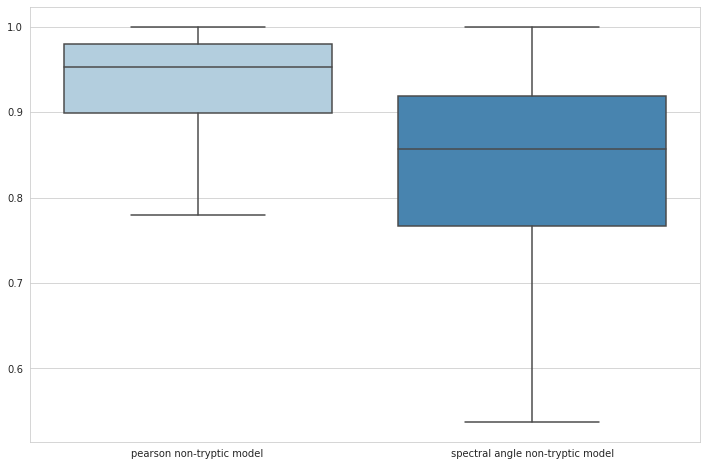

In [48]:
plt.figure(figsize=(12, 8))
model_perf = pd.DataFrame(columns=["pearson non-tryptic model", "spectral angle non-tryptic model"])
model_perf["pearson non-tryptic model"] = pear_corr
model_perf["spectral angle non-tryptic model"] = spec_corr
sns.set_style("whitegrid")
ax = sns.boxplot(data = model_perf, palette="Blues",showfliers = False)


plt.show()

# Non tryptic B_model

In [49]:
vectors, targets, psmids = load_data("data/non_tryptic_train.pkl", "B")

In [50]:
upeps = psmids.unique()
np.random.shuffle(upeps)
test_psms = upeps[:int(len(upeps) * 0.1)]

train_vectors = vectors[~psmids.isin(test_psms)]
train_targets = targets[~psmids.isin(test_psms)]
train_psmids = psmids[~psmids.isin(test_psms)]

test_vectors = vectors[psmids.isin(test_psms)]
test_targets = targets[psmids.isin(test_psms)]
test_psmids = psmids[psmids.isin(test_psms)]

In [51]:
xtrain = xgb.DMatrix(train_vectors, label=train_targets)
xtest = xgb.DMatrix(test_vectors, label=test_targets)
evallist = [(xtrain, 'train'),(xtest, 'test')]

In [52]:
space= {
    'eta': hp.loguniform('eta', np.log(0.01), np.log(1)),
    'max_depth': hp.quniform('max_depth', 3, 18, 1),
    'max_leaves': hp.quniform('max_leaves', 5, 500, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'gamma' : hp.uniform ('gamma', 0.0,1),
    'min_child_weight' : hp.quniform('min_child_weight', 0, 500, 1),
    'subsample': hp.quniform('subsample', 0.5, 1 ,0.1),
    'reg_alpha': hp.quniform('reg_alpha', 0, 5 ,0.1)
}

In [53]:
def objective(space):
    params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    "eval_metric": 'rmse',
    "eta": space["eta"],
    "max_depth": int(space['max_depth']),
    "grow_policy":"lossguide",
    "max_leaves":int(space["max_leaves"]),
    "min_child_weight": int(space["min_child_weight"]),
    "gamma": space['gamma'],
    "reg_lambda" : space['reg_lambda'],
    "colsample_bytree": space['colsample_bytree'],
    "subsample" : space["subsample"],
    "reg_alpha" : space["reg_alpha"]
    }
    print(params)
    tmp = xgb.cv(params, xtrain, nfold=4, num_boost_round=400, early_stopping_rounds=10, verbose_eval=True)
    rmse = tmp['test-rmse-mean'].min()

    print ("rmse:", rmse)
    return {'loss': rmse, 'status': STATUS_OK, "params": params}

In [54]:
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 25,
                        trials = trials)


best_hyperparams

{'nthread': 64, 'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'eta': 0.6243771331953293, 'max_depth': 6, 'grow_policy': 'lossguide', 'max_leaves': 314, 'min_child_weight': 365, 'gamma': 0.7836709539755988, 'reg_lambda': 0.22903640410256199, 'colsample_bytree': 0.890231377233355, 'subsample': 0.7000000000000001, 'reg_alpha': 1.6}
[0]	train-rmse:3.65989+0.00086	test-rmse:3.66015+0.00143

[1]	train-rmse:1.84857+0.00455	test-rmse:1.84872+0.00487

[2]	train-rmse:1.36595+0.00541	test-rmse:1.36631+0.00600

[3]	train-rmse:1.24017+0.00912	test-rmse:1.24062+0.00953

[4]	train-rmse:1.20305+0.00875	test-rmse:1.20375+0.00889

[5]	train-rmse:1.17673+0.00856	test-rmse:1.17780+0.00884

[6]	train-rmse:1.15557+0.00606	test-rmse:1.15690+0.00619

[7]	train-rmse:1.14078+0.00376	test-rmse:1.14225+0.00397

[8]	train-rmse:1.12863+0.00389	test-rmse:1.13024+0.00389

[9]	train-rmse:1.11835+0.00265	test-rmse:1.12011+0.00263

[10]	train-rmse:1.10796+0.00451	test-rmse:1.10976+0.00456

[11]	train-rmse:1.10

[268]	train-rmse:0.88278+0.00099	test-rmse:0.90937+0.00084

[269]	train-rmse:0.88261+0.00096	test-rmse:0.90927+0.00085

[270]	train-rmse:0.88244+0.00097	test-rmse:0.90919+0.00084

[271]	train-rmse:0.88226+0.00104	test-rmse:0.90907+0.00083

[272]	train-rmse:0.88198+0.00111	test-rmse:0.90886+0.00069

[273]	train-rmse:0.88170+0.00110	test-rmse:0.90866+0.00072

[274]	train-rmse:0.88158+0.00112	test-rmse:0.90861+0.00072

[275]	train-rmse:0.88142+0.00111	test-rmse:0.90853+0.00071

[276]	train-rmse:0.88117+0.00111	test-rmse:0.90838+0.00070

[277]	train-rmse:0.88087+0.00118	test-rmse:0.90817+0.00080

[278]	train-rmse:0.88072+0.00117	test-rmse:0.90812+0.00080

[279]	train-rmse:0.88053+0.00118	test-rmse:0.90799+0.00084

[280]	train-rmse:0.88034+0.00116	test-rmse:0.90786+0.00085

[281]	train-rmse:0.88020+0.00118	test-rmse:0.90779+0.00086

[282]	train-rmse:0.88007+0.00116	test-rmse:0.90773+0.00085

[283]	train-rmse:0.87987+0.00113	test-rmse:0.90764+0.00084

[284]	train-rmse:0.87966+0.00110	test-rm

[0]	train-rmse:5.54075+0.00038	test-rmse:5.54163+0.00146                           

[1]	train-rmse:3.44027+0.00057	test-rmse:3.44338+0.00155                           

[2]	train-rmse:2.21240+0.00056	test-rmse:2.21959+0.00108                           

[3]	train-rmse:1.52254+0.00081	test-rmse:1.53628+0.00090                           

[4]	train-rmse:1.16175+0.00108	test-rmse:1.18352+0.00110                           

[5]	train-rmse:0.98672+0.00101	test-rmse:1.01662+0.00143                           

[6]	train-rmse:0.90440+0.00134	test-rmse:0.94077+0.00203                           

[7]	train-rmse:0.86431+0.00131	test-rmse:0.90660+0.00214                           

[8]	train-rmse:0.84357+0.00125	test-rmse:0.89042+0.00186                           

[9]	train-rmse:0.82838+0.00101	test-rmse:0.88040+0.00146                           

[10]	train-rmse:0.81758+0.00118	test-rmse:0.87372+0.00135                          

[11]	train-rmse:0.80767+0.00202	test-rmse:0.86826+0.00144        

[192]	train-rmse:0.53932+0.00092	test-rmse:0.81424+0.00168                         

[193]	train-rmse:0.53843+0.00121	test-rmse:0.81418+0.00164                         

[194]	train-rmse:0.53775+0.00128	test-rmse:0.81416+0.00163                         

[195]	train-rmse:0.53711+0.00141	test-rmse:0.81415+0.00163                         

[196]	train-rmse:0.53588+0.00148	test-rmse:0.81417+0.00163                         

[197]	train-rmse:0.53502+0.00179	test-rmse:0.81417+0.00164                         

[198]	train-rmse:0.53439+0.00174	test-rmse:0.81417+0.00166                         

[199]	train-rmse:0.53373+0.00161	test-rmse:0.81414+0.00164                         

[200]	train-rmse:0.53305+0.00142	test-rmse:0.81412+0.00165                         

[201]	train-rmse:0.53246+0.00153	test-rmse:0.81410+0.00163                         

[202]	train-rmse:0.53172+0.00106	test-rmse:0.81408+0.00164                         

[203]	train-rmse:0.53093+0.00120	test-rmse:0.81407+0.00165       

[126]	train-rmse:0.78102+0.00164	test-rmse:0.87038+0.00242                          

[127]	train-rmse:0.78027+0.00172	test-rmse:0.87027+0.00242                          

[128]	train-rmse:0.77951+0.00178	test-rmse:0.87018+0.00239                          

[129]	train-rmse:0.77909+0.00165	test-rmse:0.87011+0.00232                          

[130]	train-rmse:0.77836+0.00170	test-rmse:0.87006+0.00231                          

[131]	train-rmse:0.77784+0.00174	test-rmse:0.87000+0.00232                          

[132]	train-rmse:0.77725+0.00175	test-rmse:0.86998+0.00231                          

[133]	train-rmse:0.77678+0.00174	test-rmse:0.86993+0.00237                          

[134]	train-rmse:0.77634+0.00177	test-rmse:0.86987+0.00233                          

[135]	train-rmse:0.77568+0.00174	test-rmse:0.86983+0.00227                          

[136]	train-rmse:0.77503+0.00160	test-rmse:0.86969+0.00219                          

[137]	train-rmse:0.77459+0.00155	test-rmse:0.86964+0.0

[95]	train-rmse:0.78045+0.00170	test-rmse:0.83041+0.00118                             

[96]	train-rmse:0.77968+0.00140	test-rmse:0.82993+0.00104                             

[97]	train-rmse:0.77886+0.00133	test-rmse:0.82953+0.00103                             

[98]	train-rmse:0.77816+0.00136	test-rmse:0.82917+0.00096                             

[99]	train-rmse:0.77754+0.00144	test-rmse:0.82886+0.00104                             

[100]	train-rmse:0.77704+0.00133	test-rmse:0.82859+0.00103                            

[101]	train-rmse:0.77635+0.00117	test-rmse:0.82825+0.00109                            

[102]	train-rmse:0.77574+0.00112	test-rmse:0.82794+0.00113                            

[103]	train-rmse:0.77504+0.00097	test-rmse:0.82759+0.00116                            

[104]	train-rmse:0.77443+0.00101	test-rmse:0.82727+0.00121                            

[105]	train-rmse:0.77394+0.00093	test-rmse:0.82702+0.00126                            

[106]	train-rmse:0.77340+0.00078

[281]	train-rmse:0.70634+0.00126	test-rmse:0.80067+0.00125                            

[282]	train-rmse:0.70601+0.00119	test-rmse:0.80057+0.00124                            

[283]	train-rmse:0.70569+0.00121	test-rmse:0.80047+0.00123                            

[284]	train-rmse:0.70548+0.00123	test-rmse:0.80042+0.00121                            

[285]	train-rmse:0.70524+0.00128	test-rmse:0.80033+0.00124                            

[286]	train-rmse:0.70494+0.00135	test-rmse:0.80025+0.00125                            

[287]	train-rmse:0.70463+0.00120	test-rmse:0.80014+0.00130                            

[288]	train-rmse:0.70434+0.00126	test-rmse:0.80004+0.00130                            

[289]	train-rmse:0.70407+0.00130	test-rmse:0.79997+0.00127                            

[290]	train-rmse:0.70382+0.00137	test-rmse:0.79991+0.00128                            

[291]	train-rmse:0.70358+0.00136	test-rmse:0.79986+0.00128                            

[292]	train-rmse:0.70328+0.00137

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[275]	train-rmse:0.86558+0.00071	test-rmse:0.88547+0.00087

[276]	train-rmse:0.86525+0.00074	test-rmse:0.88521+0.00086                     

[277]	train-rmse:0.86488+0.00077	test-rmse:0.88490+0.00087                     

[278]	train-rmse:0.86449+0.00074	test-rmse:0.88457+0.00092                     

[279]	train-rmse:0.86414+0.00071	test-rmse:0.88427+0.00091                     

[280]	train-rmse:0.86378+0.00080	test-rmse:0.88397+0.00090                     

[281]	train-rmse:0.86338+0.00081	test-rmse:0.88363+0.00090                     

[282]	train-rmse:0.86303+0.00080	test-rmse:0.88335+0.00086                     

[283]	train-rmse:0.86265+0.00076	test-rmse:0.88303+0.00093                     

[284]	train-rmse:0.86228+0.00080	test-rmse:0.88273+0.00093                     

[285]	train-rmse:0.86193+0.00085	test-rmse:0.88244+0.00091                     

[286]	train-rmse:0.86161+0.00080	test-rmse:0.88217+0.00092                     

[287]	train-rmse:0.86129+0.00080	test-rmse:0.8819

[70]	train-rmse:0.80956+0.00118	test-rmse:0.84678+0.00210                      

[71]	train-rmse:0.80862+0.00111	test-rmse:0.84621+0.00208                      

[72]	train-rmse:0.80775+0.00111	test-rmse:0.84571+0.00203                      

[73]	train-rmse:0.80669+0.00120	test-rmse:0.84504+0.00208                      

[74]	train-rmse:0.80559+0.00097	test-rmse:0.84434+0.00182                      

[75]	train-rmse:0.80484+0.00110	test-rmse:0.84393+0.00181                      

[76]	train-rmse:0.80380+0.00120	test-rmse:0.84336+0.00190                      

[77]	train-rmse:0.80296+0.00115	test-rmse:0.84292+0.00185                      

[78]	train-rmse:0.80216+0.00107	test-rmse:0.84248+0.00183                      

[79]	train-rmse:0.80145+0.00098	test-rmse:0.84206+0.00188                      

[80]	train-rmse:0.80076+0.00115	test-rmse:0.84170+0.00192                      

[81]	train-rmse:0.79994+0.00106	test-rmse:0.84125+0.00184                      

[82]	train-rmse:0.79915+0.00

[272]	train-rmse:0.71403+0.00098	test-rmse:0.80655+0.00139                     

[273]	train-rmse:0.71375+0.00102	test-rmse:0.80648+0.00140                     

[274]	train-rmse:0.71351+0.00102	test-rmse:0.80641+0.00139                     

[275]	train-rmse:0.71327+0.00100	test-rmse:0.80635+0.00140                     

[276]	train-rmse:0.71295+0.00102	test-rmse:0.80626+0.00143                     

[277]	train-rmse:0.71260+0.00104	test-rmse:0.80616+0.00144                     

[278]	train-rmse:0.71225+0.00095	test-rmse:0.80605+0.00148                     

[279]	train-rmse:0.71199+0.00104	test-rmse:0.80597+0.00146                     

[280]	train-rmse:0.71161+0.00102	test-rmse:0.80586+0.00146                     

[281]	train-rmse:0.71126+0.00096	test-rmse:0.80579+0.00147                     

[282]	train-rmse:0.71095+0.00100	test-rmse:0.80571+0.00146                     

[283]	train-rmse:0.71064+0.00103	test-rmse:0.80564+0.00149                     

[284]	train-rmse:0.71031+0.0

[67]	train-rmse:0.81836+0.00079	test-rmse:0.85654+0.00098                      

[68]	train-rmse:0.81738+0.00062	test-rmse:0.85595+0.00110                      

[69]	train-rmse:0.81663+0.00065	test-rmse:0.85549+0.00118                      

[70]	train-rmse:0.81551+0.00097	test-rmse:0.85482+0.00109                      

[71]	train-rmse:0.81457+0.00087	test-rmse:0.85419+0.00113                      

[72]	train-rmse:0.81322+0.00088	test-rmse:0.85332+0.00099                      

[73]	train-rmse:0.81233+0.00091	test-rmse:0.85276+0.00105                      

[74]	train-rmse:0.81108+0.00102	test-rmse:0.85200+0.00083                      

[75]	train-rmse:0.81002+0.00100	test-rmse:0.85131+0.00109                      

[76]	train-rmse:0.80912+0.00102	test-rmse:0.85075+0.00115                      

[77]	train-rmse:0.80823+0.00099	test-rmse:0.85020+0.00116                      

[78]	train-rmse:0.80707+0.00097	test-rmse:0.84950+0.00108                      

[79]	train-rmse:0.80622+0.00

[269]	train-rmse:0.70769+0.00031	test-rmse:0.80578+0.00129                     

[270]	train-rmse:0.70731+0.00035	test-rmse:0.80570+0.00128                     

[271]	train-rmse:0.70700+0.00028	test-rmse:0.80561+0.00128                     

[272]	train-rmse:0.70659+0.00026	test-rmse:0.80550+0.00131                     

[273]	train-rmse:0.70620+0.00026	test-rmse:0.80539+0.00131                     

[274]	train-rmse:0.70585+0.00026	test-rmse:0.80529+0.00132                     

[275]	train-rmse:0.70546+0.00017	test-rmse:0.80516+0.00135                     

[276]	train-rmse:0.70511+0.00019	test-rmse:0.80506+0.00134                     

[277]	train-rmse:0.70473+0.00021	test-rmse:0.80498+0.00135                     

[278]	train-rmse:0.70434+0.00019	test-rmse:0.80487+0.00134                     

[279]	train-rmse:0.70403+0.00021	test-rmse:0.80480+0.00134                     

[280]	train-rmse:0.70371+0.00017	test-rmse:0.80470+0.00133                     

[281]	train-rmse:0.70330+0.0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[321]	train-rmse:0.66709+0.00191	test-rmse:0.78634+0.00083

[322]	train-rmse:0.66675+0.00180	test-rmse:0.78624+0.00085                   

[323]	train-rmse:0.66643+0.00178	test-rmse:0.78616+0.00084                   

[324]	train-rmse:0.66613+0.00180	test-rmse:0.78608+0.00085                   

[325]	train-rmse:0.66574+0.00179	test-rmse:0.78598+0.00089                   

[326]	train-rmse:0.66537+0.00182	test-rmse:0.78589+0.00090                   

[327]	train-rmse:0.66515+0.00180	test-rmse:0.78583+0.00091                   

[328]	train-rmse:0.66485+0.00182	test-rmse:0.78575+0.00091                   

[329]	train-rmse:0.66452+0.00178	test-rmse:0.78566+0.00092                   

[330]	train-rmse:0.66429+0.00175	test-rmse:0.78560+0.00093                   

[331]	train-rmse:0.66396+0.00173	test-rmse:0.78554+0.00092                   

[332]	train-rmse:0.66370+0.00171	test-rmse:0.78548+0.00093                   

[333]	train-rmse:0.66341+0.00175	test-rmse:0.78541+0.00092             

[124]	train-rmse:0.72739+0.00061	test-rmse:0.80720+0.00119                 

[125]	train-rmse:0.72666+0.00053	test-rmse:0.80691+0.00120                 

[126]	train-rmse:0.72594+0.00051	test-rmse:0.80661+0.00121                 

[127]	train-rmse:0.72525+0.00056	test-rmse:0.80632+0.00120                 

[128]	train-rmse:0.72445+0.00073	test-rmse:0.80597+0.00120                 

[129]	train-rmse:0.72359+0.00081	test-rmse:0.80560+0.00107                 

[130]	train-rmse:0.72277+0.00082	test-rmse:0.80525+0.00100                 

[131]	train-rmse:0.72204+0.00076	test-rmse:0.80499+0.00100                 

[132]	train-rmse:0.72153+0.00069	test-rmse:0.80480+0.00103                 

[133]	train-rmse:0.72097+0.00064	test-rmse:0.80457+0.00104                 

[134]	train-rmse:0.72037+0.00063	test-rmse:0.80433+0.00105                 

[135]	train-rmse:0.71953+0.00076	test-rmse:0.80399+0.00100                 

[136]	train-rmse:0.71885+0.00065	test-rmse:0.80371+0.00106                 


[336]	train-rmse:0.63063+0.00139	test-rmse:0.77808+0.00165                 

[337]	train-rmse:0.63030+0.00136	test-rmse:0.77802+0.00165                 

[338]	train-rmse:0.62992+0.00130	test-rmse:0.77795+0.00166                 

[339]	train-rmse:0.62950+0.00132	test-rmse:0.77786+0.00166                 

[340]	train-rmse:0.62917+0.00129	test-rmse:0.77780+0.00166                 

[341]	train-rmse:0.62884+0.00139	test-rmse:0.77773+0.00165                 

[342]	train-rmse:0.62853+0.00139	test-rmse:0.77766+0.00167                 

[343]	train-rmse:0.62819+0.00143	test-rmse:0.77759+0.00167                 

[344]	train-rmse:0.62780+0.00142	test-rmse:0.77752+0.00169                 

[345]	train-rmse:0.62743+0.00152	test-rmse:0.77746+0.00170                 

[346]	train-rmse:0.62706+0.00148	test-rmse:0.77738+0.00169                 

[347]	train-rmse:0.62675+0.00155	test-rmse:0.77732+0.00170                 

[348]	train-rmse:0.62644+0.00149	test-rmse:0.77727+0.00169                 


[141]	train-rmse:0.71618+0.00059	test-rmse:0.80287+0.00134                 

[142]	train-rmse:0.71558+0.00071	test-rmse:0.80265+0.00139                 

[143]	train-rmse:0.71505+0.00078	test-rmse:0.80243+0.00146                 

[144]	train-rmse:0.71450+0.00069	test-rmse:0.80224+0.00145                 

[145]	train-rmse:0.71388+0.00074	test-rmse:0.80200+0.00145                 

[146]	train-rmse:0.71320+0.00070	test-rmse:0.80176+0.00142                 

[147]	train-rmse:0.71257+0.00071	test-rmse:0.80151+0.00144                 

[148]	train-rmse:0.71196+0.00067	test-rmse:0.80128+0.00145                 

[149]	train-rmse:0.71148+0.00068	test-rmse:0.80111+0.00147                 

[150]	train-rmse:0.71092+0.00077	test-rmse:0.80094+0.00148                 

[151]	train-rmse:0.71020+0.00094	test-rmse:0.80067+0.00152                 

[152]	train-rmse:0.70963+0.00089	test-rmse:0.80047+0.00150                 

[153]	train-rmse:0.70908+0.00075	test-rmse:0.80029+0.00146                 


[353]	train-rmse:0.62801+0.00137	test-rmse:0.77895+0.00134                 

[354]	train-rmse:0.62761+0.00142	test-rmse:0.77888+0.00133                 

[355]	train-rmse:0.62720+0.00145	test-rmse:0.77881+0.00133                 

[356]	train-rmse:0.62684+0.00151	test-rmse:0.77876+0.00133                 

[357]	train-rmse:0.62648+0.00143	test-rmse:0.77869+0.00133                 

[358]	train-rmse:0.62618+0.00140	test-rmse:0.77864+0.00135                 

[359]	train-rmse:0.62585+0.00144	test-rmse:0.77858+0.00135                 

[360]	train-rmse:0.62553+0.00154	test-rmse:0.77852+0.00134                 

[361]	train-rmse:0.62526+0.00156	test-rmse:0.77847+0.00133                 

[362]	train-rmse:0.62493+0.00162	test-rmse:0.77842+0.00135                 

[363]	train-rmse:0.62458+0.00154	test-rmse:0.77837+0.00134                 

[364]	train-rmse:0.62420+0.00154	test-rmse:0.77830+0.00133                 

[365]	train-rmse:0.62377+0.00159	test-rmse:0.77823+0.00133                 


{'colsample_bytree': 0.7002269364273864,
 'eta': 0.05754126608420542,
 'gamma': 0.35987834628709725,
 'max_depth': 16.0,
 'max_leaves': 356.0,
 'min_child_weight': 85.0,
 'reg_alpha': 3.5,
 'reg_lambda': 0.7049467859206121,
 'subsample': 0.6000000000000001}

In [55]:
hyperoptimization_results = {'test-rmse-mean': [x['loss'] for x in trials.results]}
for key in trials.results[0]["params"].keys():
    hyperoptimization_results[key] = [x['params'][key] for x in trials.results]

In [56]:
df = pd.DataFrame(hyperoptimization_results)

In [57]:
df.head()

,test-rmse-mean,nthread,objective,eval_metric,eta,max_depth,grow_policy,max_leaves,min_child_weight,gamma,reg_lambda,colsample_bytree,subsample,reg_alpha
0,0.896506,64,reg:squarederror,rmse,0.624377,6,lossguide,314,365,0.783671,0.229036,0.890231,0.7,1.6
1,0.813812,64,reg:squarederror,rmse,0.395588,18,lossguide,235,216,0.029849,0.215038,0.982356,1.0,1.7
2,0.867395,64,reg:squarederror,rmse,0.433856,14,lossguide,221,459,0.748771,0.883500,0.819753,0.5,2.4
3,0.792544,64,reg:squarederror,rmse,0.131381,16,lossguide,128,411,0.046450,0.611789,0.927390,0.7,1.2
4,0.964471,64,reg:squarederror,rmse,0.287281,4,lossguide,300,439,0.909459,0.954257,0.610798,0.6,2.0


In [58]:
df.to_csv("data/Hyperopt_non_tryptic_resultsB.csv")
df.head()

,test-rmse-mean,nthread,objective,eval_metric,eta,max_depth,grow_policy,max_leaves,min_child_weight,gamma,reg_lambda,colsample_bytree,subsample,reg_alpha
0,0.896506,64,reg:squarederror,rmse,0.624377,6,lossguide,314,365,0.783671,0.229036,0.890231,0.7,1.6
1,0.813812,64,reg:squarederror,rmse,0.395588,18,lossguide,235,216,0.029849,0.215038,0.982356,1.0,1.7
2,0.867395,64,reg:squarederror,rmse,0.433856,14,lossguide,221,459,0.748771,0.883500,0.819753,0.5,2.4
3,0.792544,64,reg:squarederror,rmse,0.131381,16,lossguide,128,411,0.046450,0.611789,0.927390,0.7,1.2
4,0.964471,64,reg:squarederror,rmse,0.287281,4,lossguide,300,439,0.909459,0.954257,0.610798,0.6,2.0


In [59]:
params = {
    "nthread": 64,
    "objective": "reg:squarederror",
    #"objective": "binary:logistic",
    #"eval_metric": 'mae',
    "eval_metric": 'rmse',
    "verbosity": 1,
    "eta": 0.5,
    "max_depth": 9,
    "grow_policy":"lossguide",
    "max_leaves":100,
    "min_child_weight": 300,
    "gamma": 0.1,
    "subsample": 1,
    "lambda" : 0,
    "colsample_bytree": 1,
    "max_delta_step": 0,
}

In [60]:
params.update(best_hyperparams)

In [61]:
params["max_depth"] = int(params["max_depth"])
params["max_leaves"] = int(params["max_leaves"])
params["min_child_weight"] = int(params["min_child_weight"])


In [62]:
params

{'nthread': 64,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse',
 'verbosity': 1,
 'eta': 0.05754126608420542,
 'max_depth': 16,
 'grow_policy': 'lossguide',
 'max_leaves': 356,
 'min_child_weight': 85,
 'gamma': 0.35987834628709725,
 'subsample': 0.6000000000000001,
 'lambda': 0,
 'colsample_bytree': 0.7002269364273864,
 'max_delta_step': 0,
 'reg_alpha': 3.5,
 'reg_lambda': 0.7049467859206121}

In [63]:
bstB = xgb.train(params, xtrain, 400, evallist, maximize=False, early_stopping_rounds=10)

[0]	train-rmse:8.54967	test-rmse:8.55211
[1]	train-rmse:8.06633	test-rmse:8.06844
[2]	train-rmse:7.61168	test-rmse:7.61340
[3]	train-rmse:7.18291	test-rmse:7.18455
[4]	train-rmse:6.77882	test-rmse:6.78032
[5]	train-rmse:6.39867	test-rmse:6.39989
[6]	train-rmse:6.04073	test-rmse:6.04171
[7]	train-rmse:5.70376	test-rmse:5.70469
[8]	train-rmse:5.38680	test-rmse:5.38766
[9]	train-rmse:5.08848	test-rmse:5.08913
[10]	train-rmse:4.80771	test-rmse:4.80831
[11]	train-rmse:4.54360	test-rmse:4.54399
[12]	train-rmse:4.29518	test-rmse:4.29549
[13]	train-rmse:4.06119	test-rmse:4.06148
[14]	train-rmse:3.84163	test-rmse:3.84184
[15]	train-rmse:3.63539	test-rmse:3.63569
[16]	train-rmse:3.44172	test-rmse:3.44209
[17]	train-rmse:3.25984	test-rmse:3.26013
[18]	train-rmse:3.08906	test-rmse:3.08943
[19]	train-rmse:2.92853	test-rmse:2.92890
[20]	train-rmse:2.77801	test-rmse:2.77849
[21]	train-rmse:2.63686	test-rmse:2.63740
[22]	train-rmse:2.50472	test-rmse:2.50540
[23]	train-rmse:2.38098	test-rmse:2.38174
[2

[194]	train-rmse:0.69544	test-rmse:0.77925
[195]	train-rmse:0.69473	test-rmse:0.77900
[196]	train-rmse:0.69417	test-rmse:0.77885
[197]	train-rmse:0.69349	test-rmse:0.77853
[198]	train-rmse:0.69285	test-rmse:0.77831
[199]	train-rmse:0.69242	test-rmse:0.77816
[200]	train-rmse:0.69183	test-rmse:0.77802
[201]	train-rmse:0.69130	test-rmse:0.77788
[202]	train-rmse:0.69078	test-rmse:0.77774
[203]	train-rmse:0.69054	test-rmse:0.77760
[204]	train-rmse:0.68990	test-rmse:0.77740
[205]	train-rmse:0.68949	test-rmse:0.77731
[206]	train-rmse:0.68905	test-rmse:0.77718
[207]	train-rmse:0.68874	test-rmse:0.77709
[208]	train-rmse:0.68837	test-rmse:0.77697
[209]	train-rmse:0.68813	test-rmse:0.77686
[210]	train-rmse:0.68763	test-rmse:0.77667
[211]	train-rmse:0.68714	test-rmse:0.77655
[212]	train-rmse:0.68677	test-rmse:0.77646
[213]	train-rmse:0.68644	test-rmse:0.77636
[214]	train-rmse:0.68578	test-rmse:0.77612
[215]	train-rmse:0.68519	test-rmse:0.77595
[216]	train-rmse:0.68456	test-rmse:0.77576
[217]	train

[385]	train-rmse:0.62908	test-rmse:0.76191
[386]	train-rmse:0.62872	test-rmse:0.76187
[387]	train-rmse:0.62843	test-rmse:0.76183
[388]	train-rmse:0.62823	test-rmse:0.76182
[389]	train-rmse:0.62801	test-rmse:0.76177
[390]	train-rmse:0.62762	test-rmse:0.76171
[391]	train-rmse:0.62726	test-rmse:0.76167
[392]	train-rmse:0.62700	test-rmse:0.76163
[393]	train-rmse:0.62671	test-rmse:0.76159
[394]	train-rmse:0.62645	test-rmse:0.76150
[395]	train-rmse:0.62613	test-rmse:0.76145
[396]	train-rmse:0.62573	test-rmse:0.76141
[397]	train-rmse:0.62546	test-rmse:0.76135
[398]	train-rmse:0.62523	test-rmse:0.76133
[399]	train-rmse:0.62499	test-rmse:0.76129


In [64]:
bstB.save_model("Models/Non_tryptic_HCDb.xgboost")

In [65]:
bstB = xgb.Booster({'nthread': 64})  # init model
bstB.load_model("Models/Non_tryptic_HCDb.xgboost")

# Performance testset

In [66]:
predictions = bstB.predict(xtest)
predictions

array([-9.881416 , -4.8076463, -6.8630695, ..., -9.905228 , -9.85126  ,
       -9.327778 ], dtype=float32)

In [67]:
data = pd.DataFrame()
data["spec_id"] = test_psmids
data["test_targets"] = np.array(test_targets)
data["predictions"] = predictions

In [68]:
data.head()

,spec_id,test_targets,predictions
212,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-9.965784,-9.881416
213,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-5.546829,-4.807646
214,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-6.412992,-6.863070
215,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.159628,-7.345868
216,mzspec:PXD006939:20170303_QEh1_LC2_FaMa_ChCh_S...,-7.415829,-7.692053


In [69]:
performance = Scorer(test_psmids)
pear_corr, spec_corr  = performance.psm_score(test_targets, predictions)


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


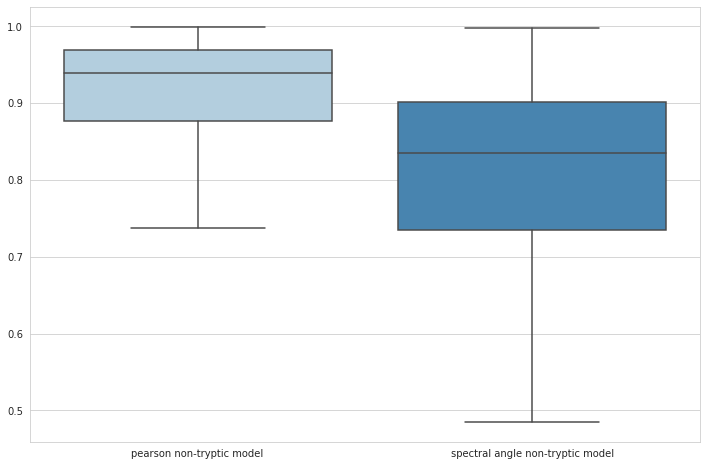

In [70]:
plt.figure(figsize=(12, 8))
model_perf = pd.DataFrame(columns=["pearson non-tryptic model", "spectral angle non-tryptic model"])
model_perf["pearson non-tryptic model"] = pear_corr
model_perf["spectral angle non-tryptic model"] = spec_corr
sns.set_style("whitegrid")
ax = sns.boxplot(data = model_perf, palette="Blues",showfliers = False)


plt.show()